# 미니 경진대회 - 배터리 수명 예측

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [1]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
!pip install --upgrade pip
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib # Matplotlib 캐시 삭제 (필수!)

Defaulting to user installation because normal site-packages is not writeable
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 33 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache director

In [2]:
# 예시 코드에 필요한 라이브러리를 불러옵니다.
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import matplotlib.font_manager as fm 
import warnings
warnings.filterwarnings('ignore')


data_dir = "/mnt/elice/dataset"

In [3]:
# --- 폰트 설정 
# 이 리스트의 폰트 중 시스템에 설치된 폰트를 찾아 사용합니다.
korean_fonts = ['Malgun Gothic', 'AppleGothic', 'NanumGothic', 'Noto Sans CJK JP', 'DejaVu Sans']

# 폰트 설정 함수
def set_korean_font():
    for font_name in korean_fonts:
        if any(font_name in f.name for f in fm.fontManager.ttflist): # 시스템에 폰트가 있는지 확인
            plt.rcParams['font.family'] = font_name
            plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
            print(f"✅ Matplotlib 한글 폰트 설정 완료: '{font_name}'")
            return
    # 모든 폰트를 찾지 못했을 경우
    plt.rcParams['font.family'] = 'sans-serif' # 기본 산세리프 폰트 사용
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
    print("⚠️ 경고: 시스템에 한글 폰트가 없어 기본 폰트를 사용합니다. 한글이 깨질 수 있습니다.")

# 폰트 설정 실행
set_korean_font()

✅ Matplotlib 한글 폰트 설정 완료: 'NanumGothic'


## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

In [4]:
train_df = pd.read_csv(os.path.join(data_dir, "train_data.csv"), index_col="Cell_ID")
test_df = pd.read_csv(os.path.join(data_dir, "test_data.csv"), index_col="Cell_ID")

# 테스트 데이터도 학습용 데이터와 같이 'Lifetime' 컬럼이 있지만 값은 비어 있습니다.
# Lifetime 컬럼을 제거해 줍니다.
test_x = test_df.drop(["Lifetime"], axis=1)
train_x = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

불러온 학습 데이터의 일부를 확인해봅시다.

In [5]:
# 학습 데이터 컬럼의 종류를 확인했습니다.
train_df.columns

Index(['CV_time_0', 'CV_time_3', 'Chg_C-rate', 'Dchg_C-rate', 'DoD', 'Q_ini',
       'Q_ini_V_high', 'Q_ini_V_low', 'Q_ini_V_mid', 'Q_initial', 'avg_stress',
       'capacity_fade_3_0', 'chg_stress', 'dchg_stress', 'delta_CV_time_3_0',
       'delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4',
       'kurt_deltaQ', 'mean_deltaQ_dchg_3_0', 'mean_dqdv_dchg_3_0',
       'mean_dqdv_dchg_high_3_0', 'mean_dqdv_dchg_low_3_0',
       'mean_dqdv_dchg_mid_3_0', 'min_deltaQ', 'multi_stress', 'skew_deltaQ',
       'var_deltaQ', 'var_deltaQ_dchg_3_0', 'var_dqdv_dchg_3_0',
       'var_dqdv_dchg_high_3_0', 'var_dqdv_dchg_low_3_0',
       'var_dqdv_dchg_mid_3_0', 'Lifetime'],
      dtype='object')

In [6]:
# 학습용 데이터의 값의 형태를 일부 확인했습니다.
train_df.head()

CV_time_0  CV_time_3  Chg_C-rate  Dchg_C-rate       DoD     Q_ini  \
Cell_ID                                                                      
1031U       1076.0      859.0         1.8          0.6  0.499119  0.284567   
1101F       1090.0      748.0         0.5          0.5  0.976741  0.285810   
1138K       1048.0      754.0         1.4          0.5  0.977683  0.287046   
1179M       1054.0      757.0         0.8          0.8  0.798062  0.281486   
1240W       1011.0      748.0         1.0          0.5  0.965539  0.284278   

         Q_ini_V_high  Q_ini_V_low  Q_ini_V_mid  Q_initial  ...  min_deltaQ  \
Cell_ID                                                     ...               
1031U       -0.088571    -0.080993    -0.115620   0.284567  ...   -0.013893   
1101F       -0.090005    -0.078695    -0.117403   0.285810  ...   -0.010924   
1138K       -0.091124    -0.079613    -0.116523   0.287046  ...   -0.022019   
1179M       -0.087527    -0.079128    -0.115236   0.281486  ...   -0.018387   
1240W       -0.090426    -0.077865    -0.116357   0.284278  ...   -0.015165   

         multi_stress  skew_deltaQ  var_deltaQ  var_deltaQ_dchg_3_0  \
Cell_ID                                                               
1031U        0.518700     0.934353    0.000042             0.000042   
1101F        0.488371     0.960777    0.000036             0.000036   
1138K        0.817988     0.608444    0.000103             0.000103   
1179M        0.638450     0.697012    0.000079             0.000079   
1240W        0.682739     0.837922    0.000058             0.000058   

         var_dqdv_dchg_3_0  var_dqdv_dchg_high_3_0  var_dqdv_dchg_low_3_0  \
Cell_ID                                                                     
1031U             0.001657                0.002272               0.000155   
1101F             0.001955                0.002748               0.000290   
1138K             0.002099                0.003927               0.000572   
1179M             0.001866                0.003187               0.000456   
1240W             0.002222                0.004377               0.000295   

         var_dqdv_dchg_mid_3_0  Lifetime  
Cell_ID                                   
1031U                 0.002816    14.425  
1101F                 0.002246    16.805  
1138K                 0.001171     7.023  
1179M                 0.001236    10.242  
1240W                 0.001685    12.827  

[5 rows x 35 columns]

In [7]:
# 학습용 데이터의 전반적인 정보를 확인합니다.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 1031U to 9908R
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CV_time_0                116 non-null    float64
 1   CV_time_3                116 non-null    float64
 2   Chg_C-rate               116 non-null    float64
 3   Dchg_C-rate              116 non-null    float64
 4   DoD                      116 non-null    float64
 5   Q_ini                    116 non-null    float64
 6   Q_ini_V_high             116 non-null    float64
 7   Q_ini_V_low              116 non-null    float64
 8   Q_ini_V_mid              116 non-null    float64
 9   Q_initial                116 non-null    float64
 10  avg_stress               116 non-null    float64
 11  capacity_fade_3_0        116 non-null    float64
 12  chg_stress               116 non-null    float64
 13  dchg_stress              116 non-null    float64
 14  delta_CV_time_3_0        

# 결측치 확인

In [8]:
# --- 1. 결측치 확인 ---
print("--- 1. 결측치 (Missing Values) 확인 ---")
missing_values_count = train_df.isnull().sum()
missing_values_percent = (train_df.isnull().sum() / len(train_df)) * 100

missing_info = pd.DataFrame({
    '결측치 개수': missing_values_count,
    '결측치 비율 (%)': missing_values_percent
})
missing_info = missing_info[missing_info['결측치 개수'] > 0].sort_values(by='결측치 비율 (%)', ascending=False)
if missing_info.empty:
    print("✨ 모든 컬럼에 결측치가 없습니다! ✨")
else:
    print(missing_info)
    print("\n결측치에 대한 처리가 필요할 수 있습니다.")

--- 1. 결측치 (Missing Values) 확인 ---
✨ 모든 컬럼에 결측치가 없습니다! ✨


# 이상치 확인

### 1. CV_time_0 & CV_time_3 & delta_CV_time_3_0


--- 2. 이상치 (Outliers) 확인 (CV_time_0, CV_time_3 - 박스 플롯) ---


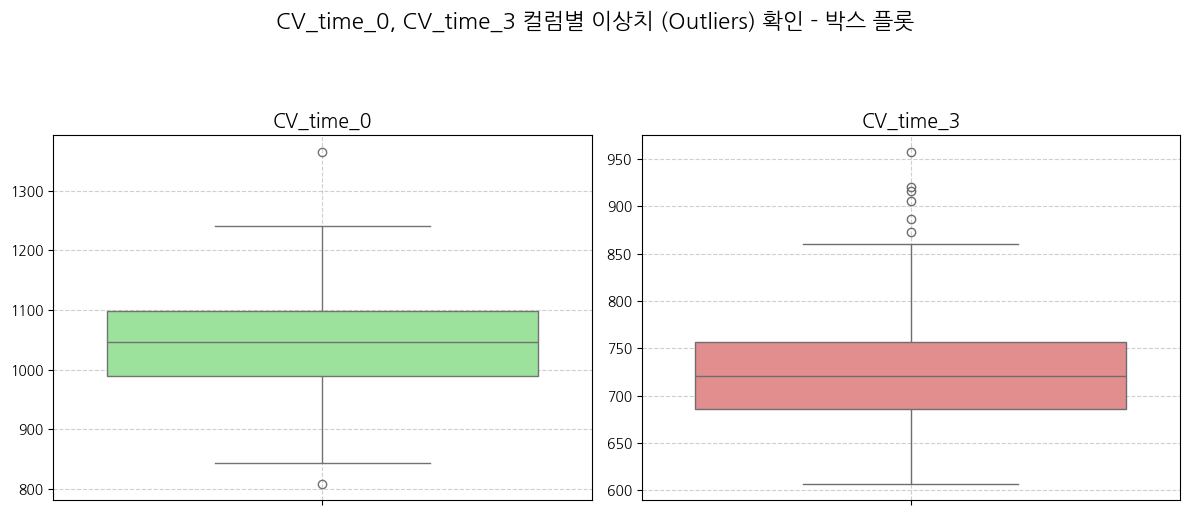


--- 3. 이상치 (Outliers) 확인 (CV_time_0, CV_time_3 - 히스토그램/KDE) ---


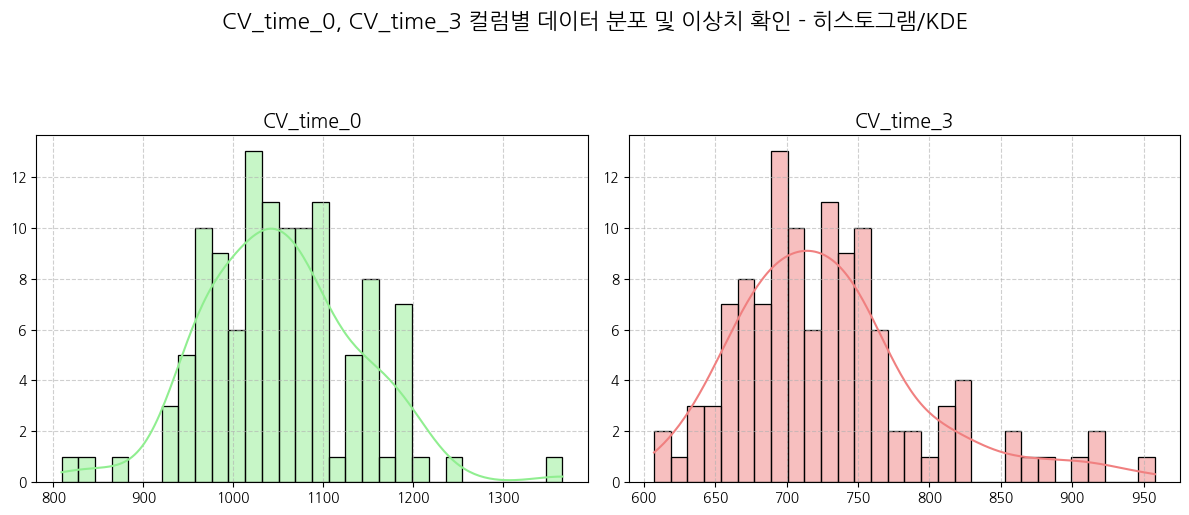

In [9]:
# --- 2. 이상치 (Outliers) 확인 (Box Plot) ---
print("\n--- 2. 이상치 (Outliers) 확인 (CV_time_0, CV_time_3 - 박스 플롯) ---")

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1행 2열로 그래프를 그림
fig.suptitle('CV_time_0, CV_time_3 컬럼별 이상치 (Outliers) 확인 - 박스 플롯', fontsize=16, y=1.05)

# CV_time_0 박스 플롯
sns.boxplot(y=train_df['CV_time_0'].dropna(), ax=axes[0], color='lightgreen')
axes[0].set_title('CV_time_0', fontsize=14)
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', labelsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

# CV_time_3 박스 플롯
sns.boxplot(y=train_df['CV_time_3'].dropna(), ax=axes[1], color='lightcoral')
axes[1].set_title('CV_time_3', fontsize=14)
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', labelsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. 이상치 (Outliers) 확인 (Histogram/KDE) ---
print("\n--- 3. 이상치 (Outliers) 확인 (CV_time_0, CV_time_3 - 히스토그램/KDE) ---")

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1행 2열로 그래프를 그림
fig.suptitle('CV_time_0, CV_time_3 컬럼별 데이터 분포 및 이상치 확인 - 히스토그램/KDE', fontsize=16, y=1.05)

# CV_time_0 히스토그램/KDE 플롯
sns.histplot(train_df['CV_time_0'].dropna(), kde=True, ax=axes[0], color='lightgreen', bins=30)
axes[0].set_title('CV_time_0', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', labelsize=10)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

# CV_time_3 히스토그램/KDE 플롯
sns.histplot(train_df['CV_time_3'].dropna(), kde=True, ax=axes[1], color='lightcoral', bins=30)
axes[1].set_title('CV_time_3', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1. 박스플롯
- CV_time_0: 위와 아래에 이상치 있음
- CV_time_3: 아래에 이상치 있음 (일부 배터리는 충전이 더 오래 걸렸음)

2. 히스토그램
- 히스토그램의 전체적인 중심이 왼쪽으로 이동했다 > 시간에 따라 충전에 걸리는 시간이 전반적으로 짧아졌다

시간이 지남에 따라 충전시간이 늘어날 것이라고 생각했는데 산점도의 결과를 보니 시간이 지남에 따라 충전시간이 감소했다.
전체적인 배터리 용량이 줄었다고도 생각할 수 있다.

이상치를 좀 더 확인해보자. 

In [10]:
# IQR (사분위 범위) 계산 함수 정의
def get_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

print("\n--- CV_time_0 이상치 데이터 ---")
cv_time_0_outliers = get_outliers_iqr(train_df.dropna(subset=['CV_time_0']), 'CV_time_0')
print(cv_time_0_outliers[['CV_time_0', 'Lifetime']]) # 이상치와 Lifetime 값 함께 출력

print("\n--- CV_time_3 이상치 데이터 ---")
cv_time_3_outliers = get_outliers_iqr(train_df.dropna(subset=['CV_time_3']), 'CV_time_3')
print(cv_time_3_outliers[['CV_time_3', 'Lifetime']]) # 이상치와 Lifetime 값 함께 출력


# --- 수치적으로 이상치 확인 (IQR 방식) ---
Q1 = train_df['delta_CV_time_3_0'].quantile(0.25)
Q3 = train_df['delta_CV_time_3_0'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df['delta_CV_time_3_0'] < lower_bound) | (train_df['delta_CV_time_3_0'] > upper_bound)]

print(f"\n--- delta_CV_time_3_0 이상치 분석 ---")
print(f"Q1 (1사분위수): {Q1:.2f}")
print(f"Q3 (3사분위수): {Q3:.2f}")
print(f"IQR (사분위 범위): {IQR:.2f}")
print(f"하한선 (Lower Bound): {lower_bound:.2f}")
print(f"상한선 (Upper Bound): {upper_bound:.2f}")

if not outliers.empty:
    print(f"\n발견된 이상치 개수: {len(outliers)}개")
    print("\n--- 이상치 데이터 ---")
    print(outliers[['delta_CV_time_3_0', 'Lifetime', 'capacity_fade_3_0']]) # 이상치와 관련 타겟 변수도 함께 출력
else:
    print("\n이상치가 발견되지 않았습니다.")


--- CV_time_0 이상치 데이터 ---
         CV_time_0  Lifetime
Cell_ID                     
2987V        809.0    15.046
5275P       1366.0    13.129

--- CV_time_3 이상치 데이터 ---
         CV_time_3  Lifetime
Cell_ID                     
1763P        906.0    16.230
3254R        958.0     3.724
5275P        920.0    13.129
5939Y        916.0    18.538
8419G        887.0     4.047
8764P        873.0    14.338

--- delta_CV_time_3_0 이상치 분석 ---
Q1 (1사분위수): -389.25
Q3 (3사분위수): -274.00
IQR (사분위 범위): 115.25
하한선 (Lower Bound): -562.12
상한선 (Upper Bound): -101.12

이상치가 발견되지 않았습니다.


In [11]:
# --- 6. 이상치 비율 계산 및 출력 ---
print("\n--- 이상치 비율 분석 ---")
total_data_count = len(train_df)

# 모든 유니크한 이상치 Cell_ID의 개수를 세기
all_unique_outlier_cell_ids = set(cv_time_0_outliers.index.tolist() + cv_time_3_outliers.index.tolist())
total_outlier_count = len(all_unique_outlier_cell_ids)

print(f"전체 배터리 개수: {total_data_count}개")
print(f"총 유니크한 이상치 배터리 개수 (CV_time_0 또는 CV_time_3 중 하나라도 이상치인 경우): {total_outlier_count}개")

outlier_percentage = (total_outlier_count / total_data_count) * 100
print(f"이상치 배터리 비율: {outlier_percentage:.2f}%")

# --- 7. 제거 결정 제안 ---
print("\n--- 이상치 제거 결정 가이드 ---")
if outlier_percentage < 1:
    print(f"✅ 이상치 비율이 {outlier_percentage:.2f}%로 매우 낮으므로, 제거를 고려할 수 있습니다. (예: train_df.drop(all_unique_outlier_cell_ids, inplace=True))")
    print("그러나 해당 이상치가 '불량 배터리'와 같이 중요한 의미를 가질 수 있다면, 별도 분석도 고려해주세요.")
elif 1 <= outlier_percentage < 5:
    print(f"⚠️ 이상치 비율이 {outlier_percentage:.2f}%로 낮은 편이지만, 제거 전 다시 한번 의미를 파악하는 것을 권장합니다.")
    print("제거했을 때와 제거하지 않았을 때의 분석 결과를 비교해보거나, 다른 변수들과의 관계를 추가적으로 확인해보세요.")
else:
    print(f"❌ 이상치 비율이 {outlier_percentage:.2f}%로 비교적 높습니다. 단순 제거보다는 이상치를 별도로 분석하거나, 다른 이상치 처리 방법(예: 값 대체, 특정 모델 사용)을 고려하는 것이 좋습니다.")



--- 이상치 비율 분석 ---
전체 배터리 개수: 116개
총 유니크한 이상치 배터리 개수 (CV_time_0 또는 CV_time_3 중 하나라도 이상치인 경우): 7개
이상치 배터리 비율: 6.03%

--- 이상치 제거 결정 가이드 ---
❌ 이상치 비율이 6.03%로 비교적 높습니다. 단순 제거보다는 이상치를 별도로 분석하거나, 다른 이상치 처리 방법(예: 값 대체, 특정 모델 사용)을 고려하는 것이 좋습니다.


비선형 구조와 이상치에 강한 트리 모델을 사용할 예정이기도 하고 상관계수도 봐야해서 일단 이상치는 건들이지 않고 놔둘 예정임

delta_CV_time의 값이 해당 컬럼들의 값의 차와 같은지 확인한다.

In [12]:
# --- 'CV_time_3'과 'CV_time_0'의 직접적인 차이 계산 (확인용) ---
train_df['delta_CV_time_3_0_check'] = train_df['CV_time_3'] - train_df['CV_time_0']

# --- 두 컬럼이 완전히 같은지 확인 ---
are_they_equal = (train_df['delta_CV_time_3_0'] == train_df['delta_CV_time_3_0_check']).all()

print(f"--- 'delta_CV_time_3_0'와 'CV_time_3 - CV_time_0'의 값이 모두 동일한가? {are_they_equal} ---")

if not are_they_equal:
    print("\n값이 다른 행이 있습니다. 첫 5개 행을 비교합니다:")
    print(train_df[['CV_time_0', 'CV_time_3', 'delta_CV_time_3_0', 'delta_CV_time_3_0_check']].head())
    print("\n값이 다른 행의 개수:", (train_df['delta_CV_time_3_0'] != train_df['delta_CV_time_3_0_check']).sum())
else:
    print("\n두 컬럼의 값이 완벽하게 일치합니다!")


--- 'delta_CV_time_3_0'와 'CV_time_3 - CV_time_0'의 값이 모두 동일한가? True ---

두 컬럼의 값이 완벽하게 일치합니다!


좀 전에 확인해본 결과를 바탕으로 생각해보면
배터리는 시간이 지날 수록 배터리 충전시간이 감소했다. 
배터리의 수명에 따라 배터리 충전시간이 감소할 수 있지 않을까?
CV time 관련해서 배터리 수명/용량 변화량 간의 상관관계를 확인해보자.

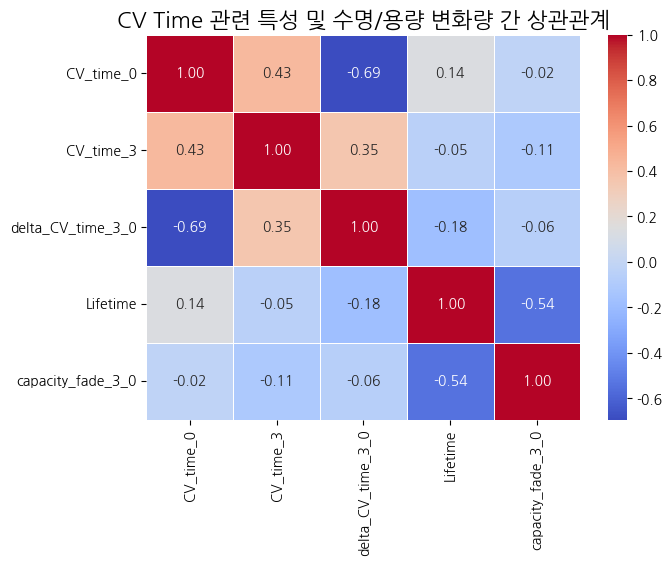

In [13]:
# --- 상관관계를 계산할 컬럼 리스트 ---
features_of_interest = ['CV_time_0', 'CV_time_3', 'delta_CV_time_3_0', 'Lifetime', 'capacity_fade_3_0']

# --- 상관관계 행렬 계산 ---
correlation_matrix = train_df[features_of_interest].corr()

# --- 히트맵 시각화 ---
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('CV Time 관련 특성 및 수명/용량 변화량 간 상관관계', fontsize=16)
plt.show()


3개의 팩터 모두 상관관계가 낮다고 나왔다.

무의미한 값인걸까? 아니면 비선형적인 패턴이 있는 걸까?

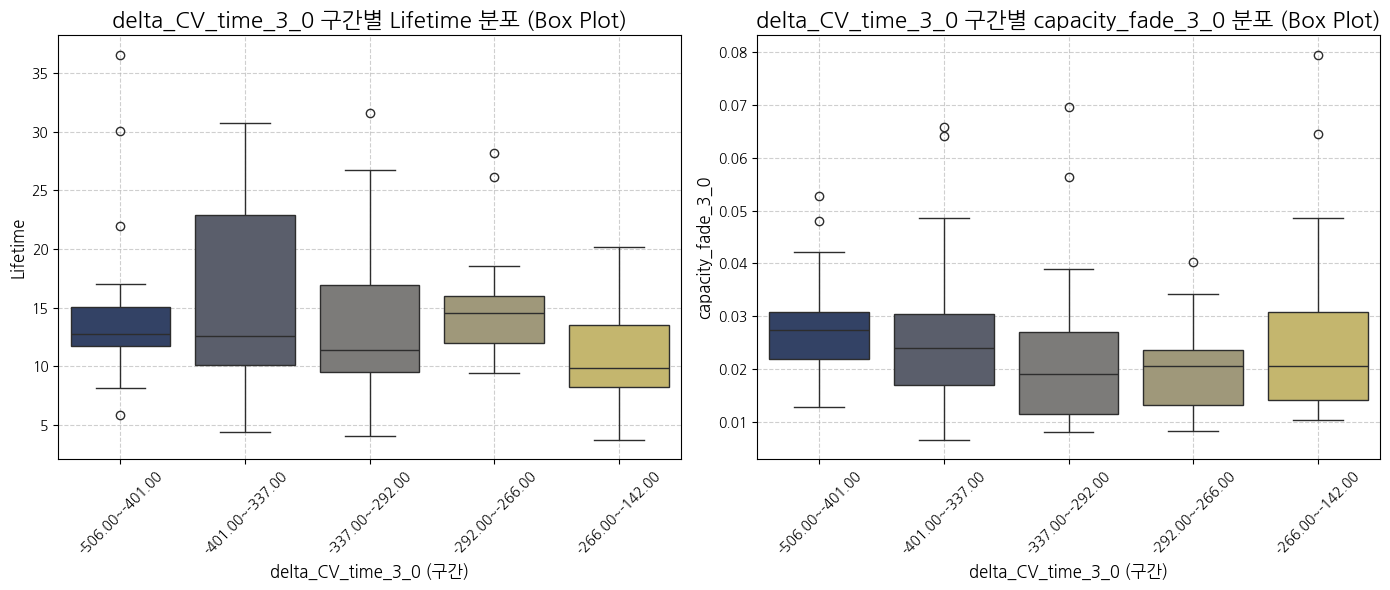

In [14]:
# --- 분석할 단일 CV Time 특성 ---
cv_feature_to_analyze = 'delta_CV_time_3_0'
target_features = ['Lifetime', 'capacity_fade_3_0']

num_bins = 5 # 나눌 구간의 개수 설정 (필요에 따라 조절)

# 해당 CV Time 특성의 min/max 값을 기준으로 구간 생성 (qcut 사용)
min_val = train_df[cv_feature_to_analyze].min()
max_val = train_df[cv_feature_to_analyze].max()
bins = pd.qcut(train_df[cv_feature_to_analyze], q=num_bins, retbins=True, duplicates='drop')[1]
labels = [f'{bins[i]:.2f}~{bins[i+1]:.2f}' for i in range(len(bins)-1)]

# 임시 구간 컬럼 생성 (데이터프레임에 영구 추가 안함)
binned_cv_feature = pd.cut(train_df[cv_feature_to_analyze], bins=bins, labels=labels, right=True, include_lowest=True, ordered=True)

# --- delta_CV_time_3_0 와 Lifetime/capacity_fade_3_0 관계 박스 플롯 ---
plt.figure(figsize=(14, 6)) # 두 개의 플롯을 한 줄에
plot_num = 1

for target_feature in target_features:
    plt.subplot(1, 2, plot_num) # 1행 2열 중 현재 플롯
    sns.boxplot(x=binned_cv_feature, y=target_feature, data=train_df, palette='cividis') # 색상 변경
    plt.title(f'{cv_feature_to_analyze} 구간별 {target_feature} 분포 (Box Plot)', fontsize=16)
    plt.xlabel(f'{cv_feature_to_analyze} (구간)', fontsize=12)
    plt.ylabel(target_feature, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plot_num += 1

plt.tight_layout()
plt.show()


delta_CV_time에는 이상치값도 없었어

그렇다면 이건 패턴의 신뢰도가 있다는 소리 같고
CV_Time과 Lifetime에 최적점이 존재하는 비선형적인 관계가 있다고 보는게 좋을 것 같아 

### 2. chg_C-rate & dchg_C-rate

충전율/방전율은 배터리 수명이나 열화에 큰 영향을 미칠 수 있는 요인이라고 생각한다.


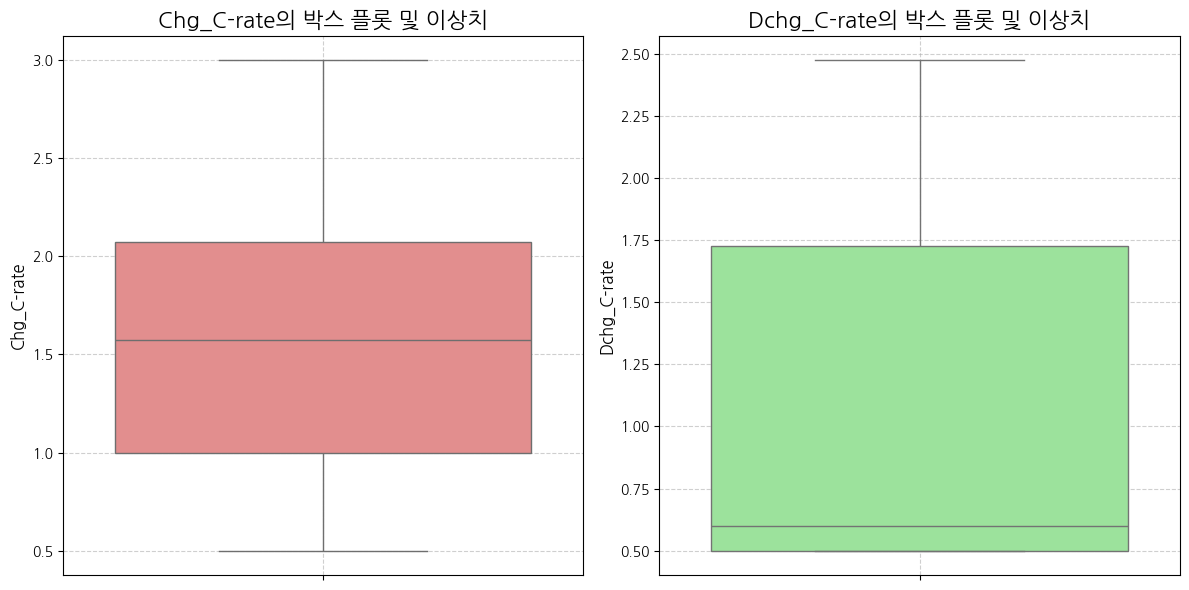


--- 충전율 및 방전율 이상치 분석 ---

--- Chg_C-rate ---
Q1 (1사분위수): 1.00
Q3 (3사분위수): 2.08
IQR (사분위 범위): 1.08
하한선 (Lower Bound): -0.61
상한선 (Upper Bound): 3.69
이상치가 발견되지 않았습니다.

--- Dchg_C-rate ---
Q1 (1사분위수): 0.50
Q3 (3사분위수): 1.73
IQR (사분위 범위): 1.23
하한선 (Lower Bound): -1.34
상한선 (Upper Bound): 3.56
이상치가 발견되지 않았습니다.


In [15]:
# --- 이상치 확인을 위한 컬럼 리스트 ---
rate_features = ['Chg_C-rate', 'Dchg_C-rate']

# --- 각 충전율/방전율 컬럼의 박스 플롯 및 이상치 확인 ---
plt.figure(figsize=(12, 6))

for i, feature in enumerate(rate_features):
    plt.subplot(1, 2, i + 1) # 1행 2열로 두 개의 플롯을 나란히
    sns.boxplot(y=train_df[feature], color='lightcoral' if feature == 'Chg_C-rate' else 'lightgreen')
    plt.title(f'{feature}의 박스 플롯 및 이상치', fontsize=16)
    plt.ylabel(feature, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- 수치적으로 이상치 확인 (IQR 방식) ---
print("\n--- 충전율 및 방전율 이상치 분석 ---")
for feature in rate_features:
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]

    print(f"\n--- {feature} ---")
    print(f"Q1 (1사분위수): {Q1:.2f}")
    print(f"Q3 (3사분위수): {Q3:.2f}")
    print(f"IQR (사분위 범위): {IQR:.2f}")
    print(f"하한선 (Lower Bound): {lower_bound:.2f}")
    print(f"상한선 (Upper Bound): {upper_bound:.2f}")

    if not outliers.empty:
        print(f"발견된 이상치 개수: {len(outliers)}개")
        print("--- 이상치 데이터 ---")
        print(outliers[[feature, 'Lifetime', 'capacity_fade_3_0']]) # 이상치와 관련 타겟 변수도 함께 출력
    else:
        print("이상치가 발견되지 않았습니다.")


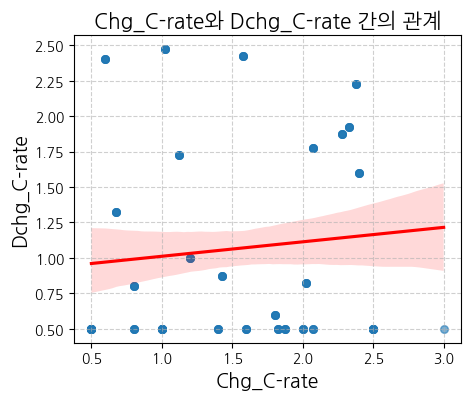


--- Chg_C-rate와 Dchg_C-rate 간의 상관계수: 0.10 ---


In [16]:
# --- Chg_C-rate와 Dchg_C-rate 간의 관계 시각화 (산점도) ---
plt.figure(figsize=(5, 4))
sns.regplot(x='Chg_C-rate', y='Dchg_C-rate', data=train_df, scatter_kws={'alpha':0.6, 's':30}, line_kws={'color':'red'})
plt.title('Chg_C-rate와 Dchg_C-rate 간의 관계', fontsize=15)
plt.xlabel('Chg_C-rate', fontsize=14)
plt.ylabel('Dchg_C-rate', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 수치적인 상관계수 계산 ---
correlation = train_df['Chg_C-rate'].corr(train_df['Dchg_C-rate'])
print(f"\n--- Chg_C-rate와 Dchg_C-rate 간의 상관계수: {correlation:.2f} ---")

두 컬럼이 서로에게 직접적인 관계가 없고 이상치는 확인되지 않았다.



충전율/방전율이 높을수록 배터리 성능저하가 빨리 된다고 생각했다.

그 상관관계를 알아보자.

1. 충전/방전율 vs 수명

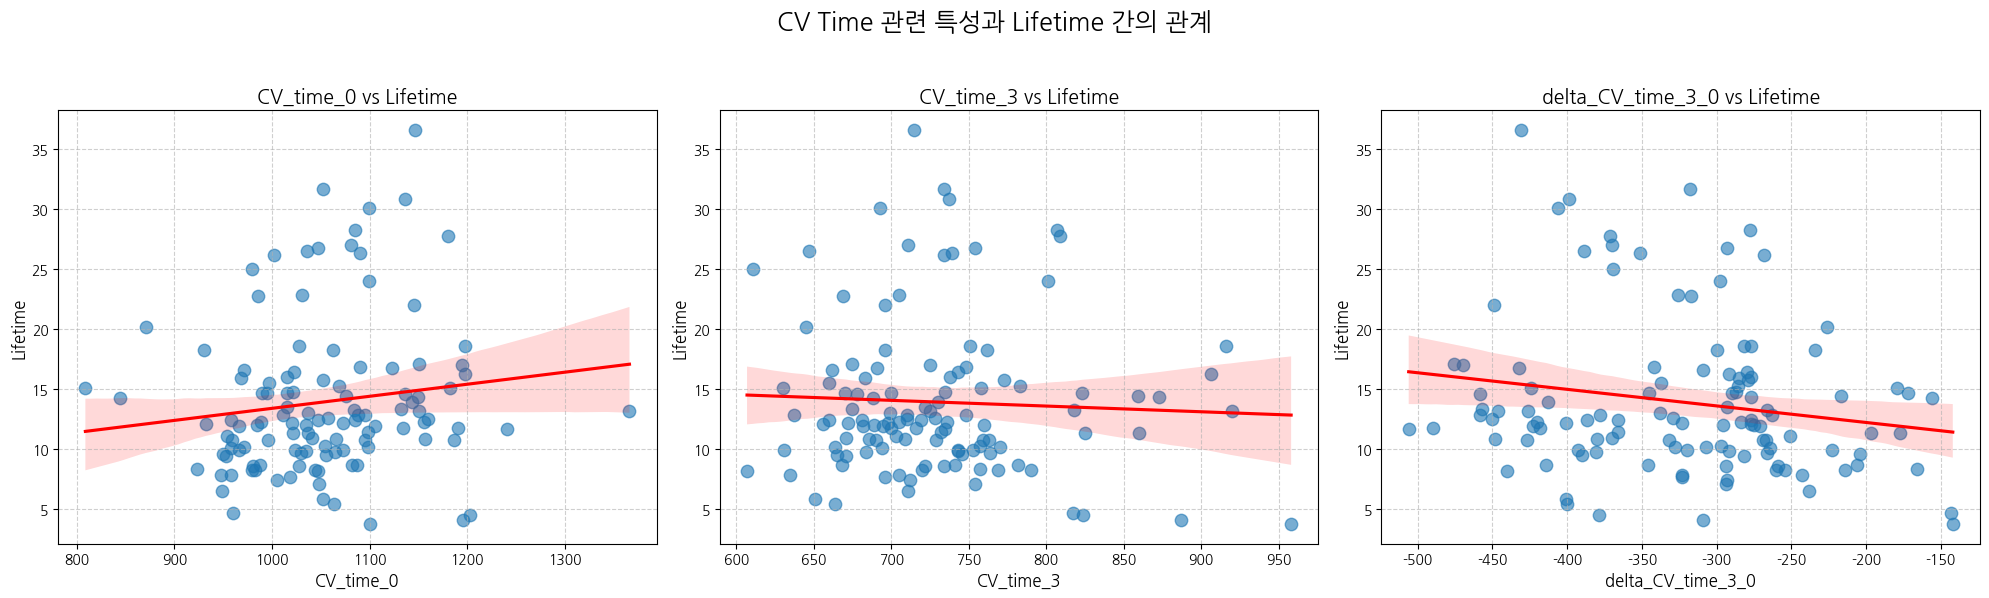

--- CV Time 관련 특성과 Lifetime 간의 상관관계 ---
  CV_time_0 vs Lifetime: 0.1352
  CV_time_3 vs Lifetime: -0.0493
  delta_CV_time_3_0 vs Lifetime: -0.1794


In [17]:
# --- 상관관계 계산을 위한 특성 리스트 ---
cv_time_features = [
    'CV_time_0',
    'CV_time_3',
    'delta_CV_time_3_0' # 계산된 특성 추가
]


# --- 서브플롯 생성 (1행 3열) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 3개의 서브플롯

for i, feature in enumerate(cv_time_features):
    if feature in train_df.columns:
        sns.regplot(x=feature, y='Lifetime',
                    data=train_df.dropna(subset=[feature, 'Lifetime']),
                    scatter_kws={'alpha':0.6, 's':80},
                    line_kws={'color':'red'}, # 회귀선 색상
                    ax=axes[i])
        axes[i].set_title(f'{feature} vs Lifetime', fontsize=14)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('Lifetime', fontsize=12)
        axes[i].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[i].set_title(f"'{feature}' 컬럼 없음", fontsize=14)
        axes[i].text(0.5, 0.5, f"데이터에 '{feature}' 없음", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.suptitle('CV Time 관련 특성과 Lifetime 간의 관계', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("--- CV Time 관련 특성과 Lifetime 간의 상관관계 ---")
for feature in cv_time_features:
    if feature in train_df.columns:
        corr_val = train_df[feature].corr(train_df['Lifetime'])
        print(f"  {feature} vs Lifetime: {corr_val:.4f}")
    else:
        print(f"  '{feature}' 컬럼이 데이터프레임에 없어 상관관계를 계산할 수 없습니다.")

상관관계가 거의 없는 듯한 값으로 확인되었다.

하지만, 분포가 다소 몰려있는 듯한 느낌을 산점도에서 받았는데
혹시 비선형적인 패턴이 있는 건 아닐까?? 

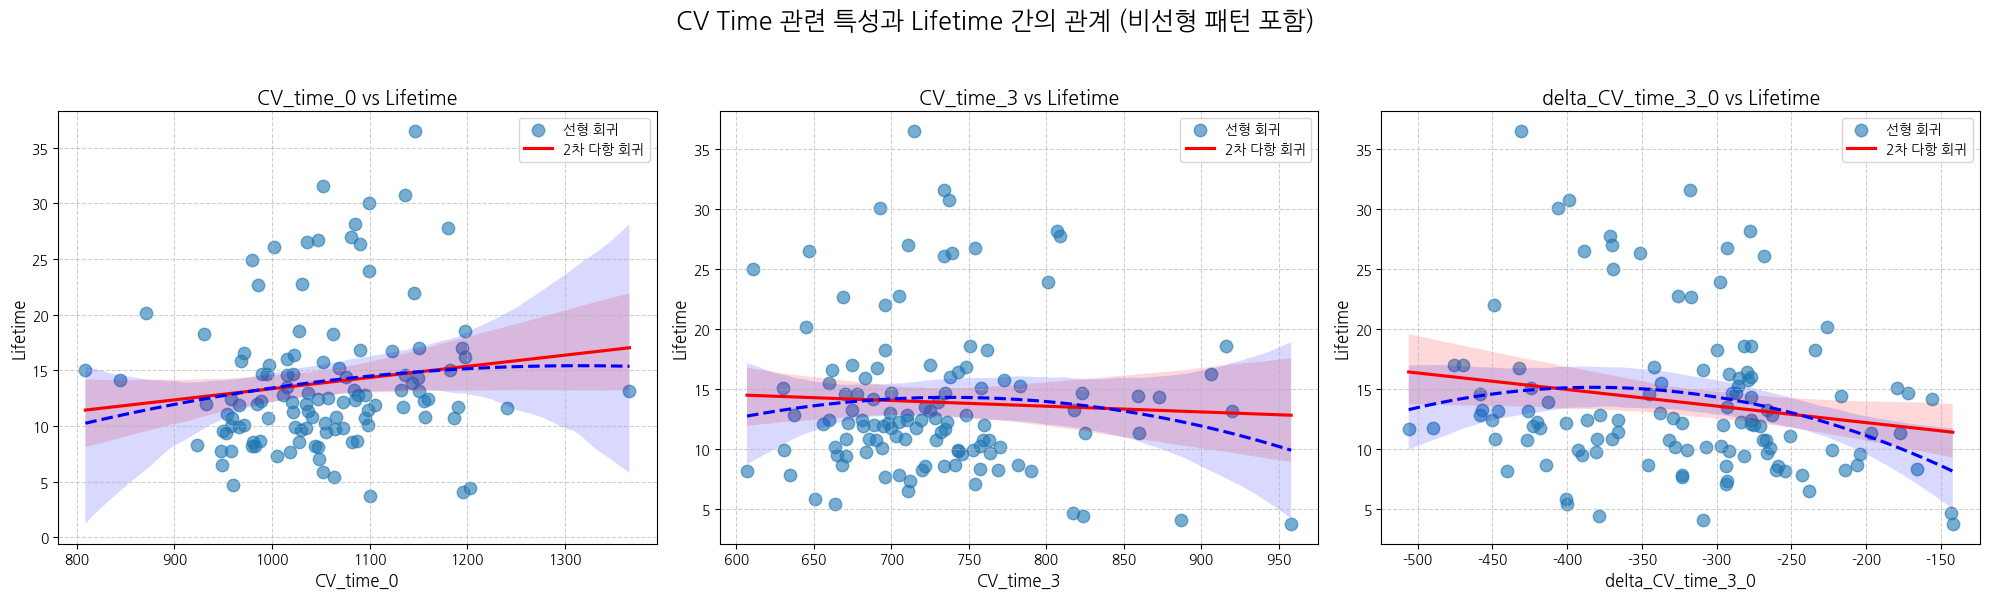

In [18]:
# --- 서브플롯 생성 (1행 3열) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 3개의 서브플롯

for i, feature in enumerate(cv_time_features):
    if feature in train_df.columns:
        # 선형 회귀선 (빨간색)
        sns.regplot(x=feature, y='Lifetime',
                    data=train_df.dropna(subset=[feature, 'Lifetime']),
                    scatter_kws={'alpha':0.6, 's':80},
                    line_kws={'color':'red', 'linestyle':'-'},
                    ax=axes[i], ci=95) # ci=95는 신뢰구간을 95%로 표시

        # 2차 다항 회귀선 (파란색 점선)
        sns.regplot(x=feature, y='Lifetime',
                    data=train_df.dropna(subset=[feature, 'Lifetime']),
                    scatter=False, # 점은 그리지 않고 선만 그리기
                    order=2,       # 2차 다항 회귀선
                    line_kws={'color':'blue', 'linestyle':'--', 'label':'2차 다항 회귀'},
                    ax=axes[i], ci=95)

        axes[i].set_title(f'{feature} vs Lifetime', fontsize=14)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('Lifetime', fontsize=12)
        axes[i].grid(True, linestyle='--', alpha=0.6)
        axes[i].legend(['선형 회귀', '2차 다항 회귀']) # 범례 추가
    else:
        axes[i].set_title(f"'{feature}' 컬럼 없음", fontsize=14)
        axes[i].text(0.5, 0.5, f"데이터에 '{feature}' 없음", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.suptitle('CV Time 관련 특성과 Lifetime 간의 관계 (비선형 패턴 포함)', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


아래쪽으로 살짝 밀집된 듯한 패턴을 보인다.

무의미하다고 단정 짓기는 어려워 보이고 모델 돌릴 때 특성 중요도 확인해보자.

2. 충전/방전율과 배터리 용량 변화량의 상관관계

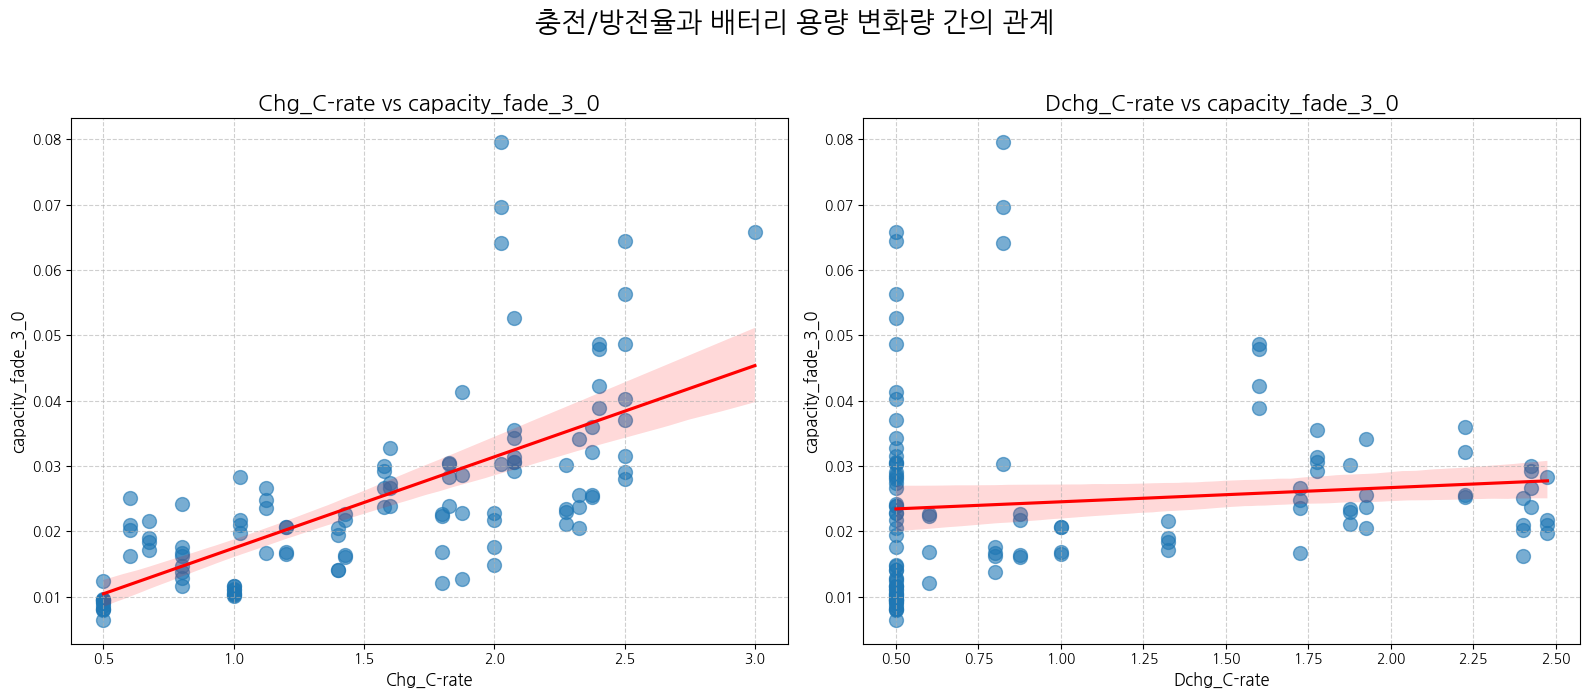


--- 충전/방전율과 배터리 용량 변화량 간의 상관계수 ---
  Chg_C-rate vs capacity_fade_3_0: 0.6837
  Dchg_C-rate vs capacity_fade_3_0: 0.1111


In [19]:
# --- 시각화할 특성 리스트 ---
c_rate_features = [
    'Chg_C-rate',
    'Dchg_C-rate'
]
target_variable = 'capacity_fade_3_0'

# --- 서브플롯 생성 (1행 2열) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7)) # 2개의 서브플롯

for i, feature in enumerate(c_rate_features):
    if feature in train_df.columns and target_variable in train_df.columns:
        sns.regplot(x=feature, y=target_variable,
                    data=train_df.dropna(subset=[feature, target_variable]),
                    scatter_kws={'alpha':0.6, 's':100},
                    line_kws={'color':'red'}, # 회귀선 색상
                    ax=axes[i], ci=95) # ci=95는 신뢰구간을 95%로 표시

        axes[i].set_title(f'{feature} vs {target_variable}', fontsize=16)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel(target_variable, fontsize=12)
        axes[i].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[i].set_title(f"'{feature}' 또는 '{target_variable}' 컬럼 없음", fontsize=16)
        axes[i].text(0.5, 0.5, f"데이터에 '{feature}' 또는 '{target_variable}' 없음", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.suptitle('충전/방전율과 배터리 용량 변화량 간의 관계', fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("\n--- 충전/방전율과 배터리 용량 변화량 간의 상관계수 ---")
for feature in c_rate_features:
    if feature in train_df.columns and target_variable in train_df.columns:
        corr_val = train_df[feature].corr(train_df[target_variable])
        print(f"  {feature} vs {target_variable}: {corr_val:.4f}")
    else:
        print(f"  '{feature}' 또는 '{target_variable}' 컬럼이 데이터프레임에 없어 상관관계를 계산할 수 없습니다.")

1. 충전율
- 높은 상관관계: 충전율이 높아질수록 배터리 용량 감소가 커진단 의미
2. 방전율
- 낮은 상관관계: 용량 변화량에 미치는 선형적인 영향은 미미하다고 볼 수 있음.

초기 용량 변화량에는 충전율이 더 큰 영향을 주는 듯!!
빠르게 충전하는 게 초기 배터리 열화에 더 큰 스트레스를 주나봐 

> 어째서 충전율에만 영향을 미치는가? 
- 배터리 열화 메커니즘의 차이 
1) 충전 과정
- 고율 충전은 배터리 내부의 전극 물질에 더 큰 스트레스를 주고, 리튬 이온이 빠르게 삽입되면서 전극 구조에 변형을 일으키기 쉬움.
- 빠른 충전시 발생할 수 있는 부반응이 열화를 가속화하는 주된 원인이 될 수 있음
2) 방전 과정
- 방전도 열화에 영향은 미치지만, 대부분의 배터리가 방전 과정에서 발생하는 스트레스에 좀 더 강하게 설계되거나, 방전율이 수명에 미치는 영향이 충전율만큼 크지 않은 경우가 있음

> 그렇다면 Dchg_C-rate가 Lifetime에 영향을 주지 않는, 정말 무의미한 데이터인가?
: 그래프의 왼쪽에 해당 컬럼의 값이 다수 쏠려있는 모습이 보임.
  비선형적인 패턴이 있을 수도 있음. 


Dchg_C-rate 최소: 0.50, 최대: 2.48

--- Dchg_C-rate 각 구간별 데이터 수 ---
Dchg_C-rate_bin
0.0~0.5     0
0.5~1.0    72
1.0~1.5     8
1.5~2.0    20
2.0~2.5    16
Name: count, dtype: int64


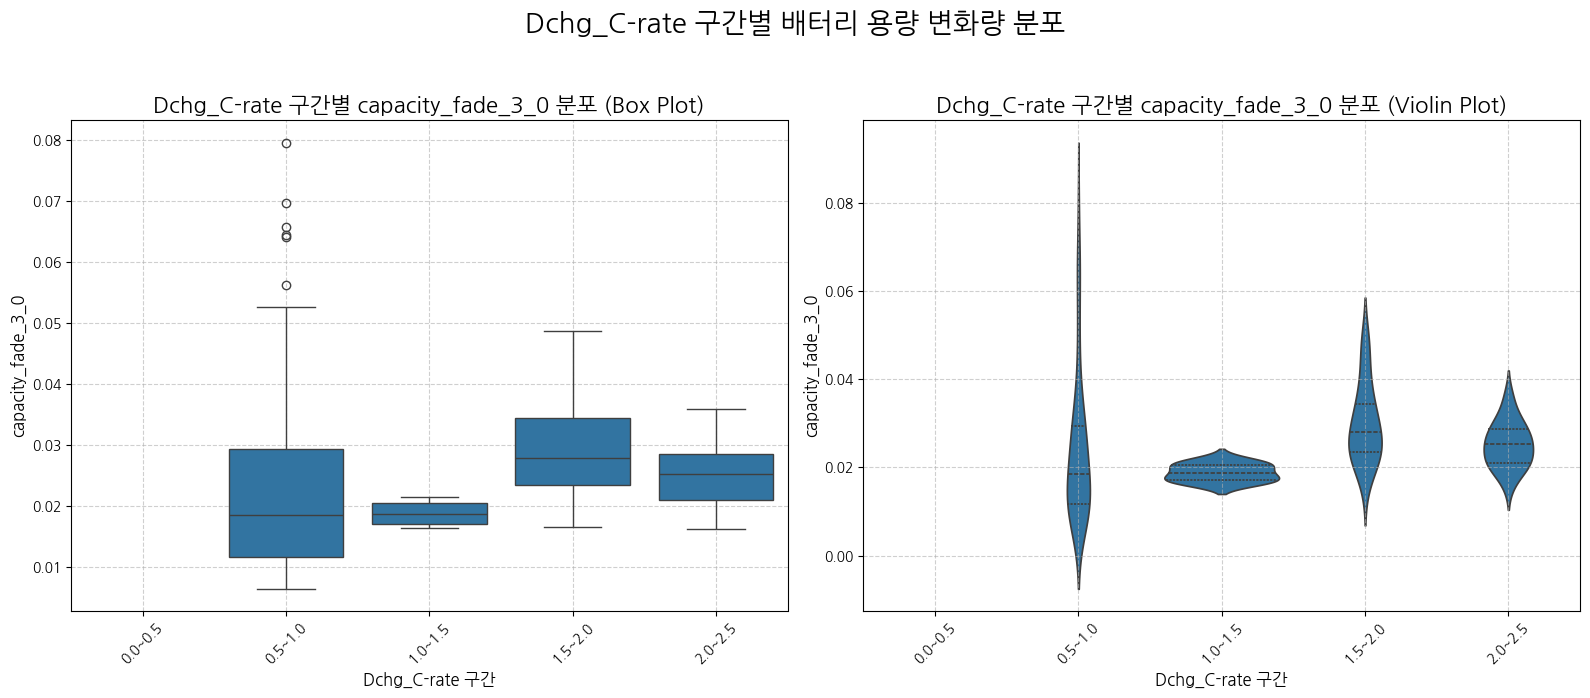

In [20]:
# --- Dchg_C-rate를 구간으로 나누기 ---
# Dchg_C-rate의 최솟값과 최댓값을 기준으로 적절한 bin을 설정
min_dchg = train_df['Dchg_C-rate'].min()
max_dchg = train_df['Dchg_C-rate'].max()
print(f"Dchg_C-rate 최소: {min_dchg:.2f}, 최대: {max_dchg:.2f}")

# 범위를 4~5개 정도의 구간으로 나누기 (데이터 분포에 따라 조정 필요)
# 예를 들어, 0.5 간격으로 bin 생성
bins = np.arange(0.0, max_dchg + 0.5, 0.5) # 0부터 최대값까지 0.5 간격으로
labels = [f'{i:.1f}~{i+0.5:.1f}' for i in bins[:-1]]
train_df['Dchg_C-rate_bin'] = pd.cut(train_df['Dchg_C-rate'], bins=bins, labels=labels, right=False)

# 만약 특정 bin에 데이터가 너무 적다면 (극단값 제외), bin 개수를 줄이거나 간격을 조정
print("\n--- Dchg_C-rate 각 구간별 데이터 수 ---")
print(train_df['Dchg_C-rate_bin'].value_counts().sort_index())

# --- 시각화 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
target_variable = 'capacity_fade_3_0'

# 1. 박스 플롯 (Box Plot)
sns.boxplot(x='Dchg_C-rate_bin', y=target_variable, data=train_df.dropna(subset=['Dchg_C-rate_bin', target_variable]), ax=axes[0])
axes[0].set_title(f'Dchg_C-rate 구간별 {target_variable} 분포 (Box Plot)', fontsize=16)
axes[0].set_xlabel('Dchg_C-rate 구간', fontsize=12)
axes[0].set_ylabel(target_variable, fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='x', rotation=45) # x축 레이블 회전

# 2. 바이올린 플롯 (Violin Plot)
sns.violinplot(x='Dchg_C-rate_bin', y=target_variable, data=train_df.dropna(subset=['Dchg_C-rate_bin', target_variable]), ax=axes[1], inner='quartile')
axes[1].set_title(f'Dchg_C-rate 구간별 {target_variable} 분포 (Violin Plot)', fontsize=16)
axes[1].set_xlabel('Dchg_C-rate 구간', fontsize=12)
axes[1].set_ylabel(target_variable, fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='x', rotation=45) # x축 레이블 회전

plt.suptitle('Dchg_C-rate 구간별 배터리 용량 변화량 분포', fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

1.0~1.5 이상을 넘어가게 되면 평균값과 분산값이 높아지는 경향을 보임.
일정 방전율 이상에서는 배터리 용량 감소가 심해진다는 비선형적인 패턴을 보임

모델링할 때 특성 중요도를 파악한 뒤 어떻게 할지 결정하자.

### 2. Q_ini & Q_ini_V_high & Q_ini_V_mid & Q_ini_V_low

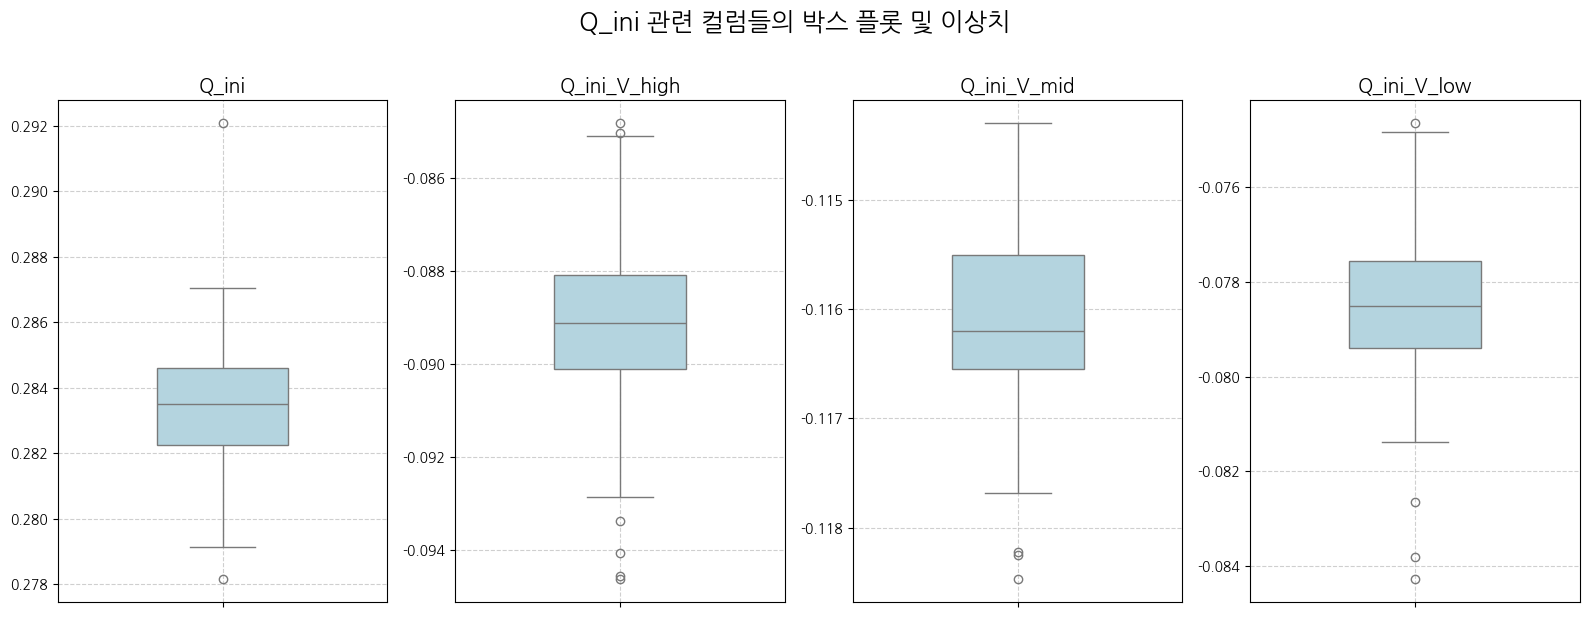

In [21]:
# --- 박스 플롯 그릴 컬럼 리스트 ---
q_ini_cols = ['Q_ini', 'Q_ini_V_high', 'Q_ini_V_mid', 'Q_ini_V_low']

# --- 박스 플롯 그리기 ---
fig, axes = plt.subplots(1, len(q_ini_cols), figsize=(len(q_ini_cols) * 4, 6)) # 컬럼 수에 맞춰 그림 크기 설정
fig.suptitle('Q_ini 관련 컬럼들의 박스 플롯 및 이상치', fontsize=18, y=1.02)

for i, col in enumerate(q_ini_cols):
    sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightblue', width=0.4)
    axes[i].set_title(col, fontsize=14)
    axes[i].set_ylabel('') # y축 레이블은 각 컬럼명으로 대체되므로 비워둠
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [22]:
# --- 이상치 비율 계산 함수 ---
def calculate_outlier_percentage(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    if len(series) == 0:
        return 0
    outlier_percentage = (len(outliers) / len(series)) * 100
    return outlier_percentage

# --- 박스 플롯 그릴 컬럼 리스트 ---
q_ini_cols = ['Q_ini', 'Q_ini_V_high', 'Q_ini_V_mid', 'Q_ini_V_low']

# --- 각 컬럼별 이상치 비율 계산 및 출력 ---
print("--- Q_ini 관련 컬럼들의 이상치 비율 ---")
outlier_percentages = {}
for col in q_ini_cols:
    if col in train_df.columns:
        percentage = calculate_outlier_percentage(train_df[col].dropna())
        outlier_percentages[col] = percentage
        print(f"'{col}': {percentage:.2f}%")
    else:
        print(f"⚠️ 경고: '{col}' 컬럼이 데이터프레임에 없습니다.")
        outlier_percentages[col] = np.nan # NaN으로 표시


--- Q_ini 관련 컬럼들의 이상치 비율 ---
'Q_ini': 1.72%
'Q_ini_V_high': 5.17%
'Q_ini_V_mid': 2.59%
'Q_ini_V_low': 3.45%


만약 해당 데이터를 써야한다면 이상치를 과감하게 삭제하고 가도 되겠다.

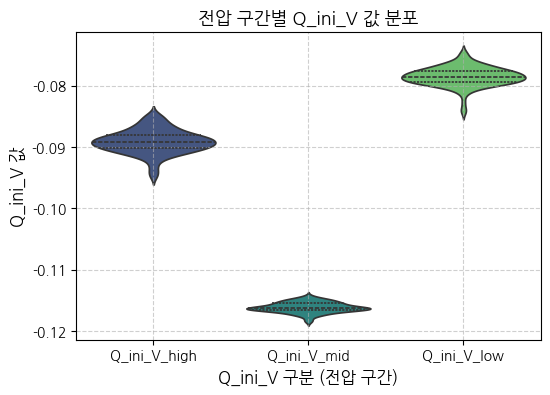

In [23]:
df_for_qini_plot = train_df[['Q_ini_V_high', 'Q_ini_V_mid', 'Q_ini_V_low']].copy()

# 부호 뒤집기 제거 (원본이 이미 음수라면)
# df_for_qini_plot[col] = -df_for_qini_plot[col]  # 이 부분 주석 처리 또는 삭제

df_melted = df_for_qini_plot.reset_index().melt(
    id_vars='Cell_ID',
    value_vars=['Q_ini_V_high', 'Q_ini_V_mid', 'Q_ini_V_low'],
    var_name='Q_ini_V_구분',
    value_name='Q_ini_V_값'
)

# 전압 구간 순서 설정
order = ['Q_ini_V_high', 'Q_ini_V_mid', 'Q_ini_V_low']
df_melted['Q_ini_V_구분'] = pd.Categorical(df_melted['Q_ini_V_구분'], categories=order, ordered=True)

# 그래프 그리기
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.violinplot(
    x='Q_ini_V_구분',
    y='Q_ini_V_값',
    data=df_melted,
    inner='quartile',
    palette='viridis'
)
plt.title('전압 구간별 Q_ini_V 값 분포', fontsize=13)
plt.xlabel('Q_ini_V 구분 (전압 구간)', fontsize=12)
plt.ylabel('Q_ini_V 값', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

왜 이렇게 중간값만 값이 튈까?

배터리 공학적 관점에서 볼 때, 중간 전압 구간의 경우, 주요 상 변화가 일어나거나 전극 물질 내부로 리튬 이온이 활발하게 삽입/탈리되는 구간임.

하짐반 이것이 반드시 손실없이 효율적으로 이루어진다는 의미는 아님.

오히려 활발한 반응성이 부반응이나 손상을 유발해 실제 측정되는 유효 용량은 낮게 나타날 수 있음.

이런 반응들은 배터리의 열화 메커니즘의 일부이고, 장기적으로 배터리 수명에 부정적인 영향을 줄 수 있음.

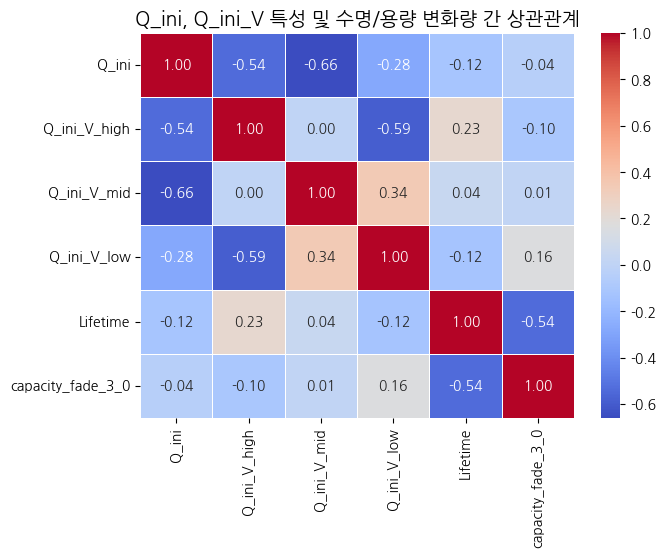

In [24]:
# --- 상관관계를 계산할 컬럼 리스트 ---
features_of_interest = ['Q_ini', 'Q_ini_V_high', 'Q_ini_V_mid', 'Q_ini_V_low', 'Lifetime', 'capacity_fade_3_0']

# --- 상관관계 행렬 계산 ---
correlation_matrix = train_df[features_of_interest].corr()

# --- 히트맵 시각화 ---
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Q_ini, Q_ini_V 특성 및 수명/용량 변화량 간 상관관계', fontsize=14)
plt.show()




그렇다면 배터리 수명/배터리 용량 변화량과 연결되어있어야 하는 것 아닌가?.. 

왜 상관계수가 낮게 나오지?
1) 비선형적인 관계
2) 복잡한 열화 메커니즘: 이 특이점이 하나의 중요한 요인일 수 있지만, 다른 지배적인 요인들이 있다면, 상대적으로 이 특이점의 선형관계는 낮아보일 수 있음
3) 초기'에 나타난 하나의 작은 특이점이 '전체 수명'이라는 매우 긴 결과와 선형적으로 강하게 연결되지 않을 수도 있어. 이 특이점이 수명을 단축시키는 '원인'이 될 수는 있지만, 그 영향이 즉각적이거나 선형적이지 않을 수도 있다는 의미임

>> 트리 모델의 강점: 비선형 관게나 복합적인 상호작용을 잘 찾아냄.


### 4. chg_stress & dchg_stress & avg_stress & multi_stress

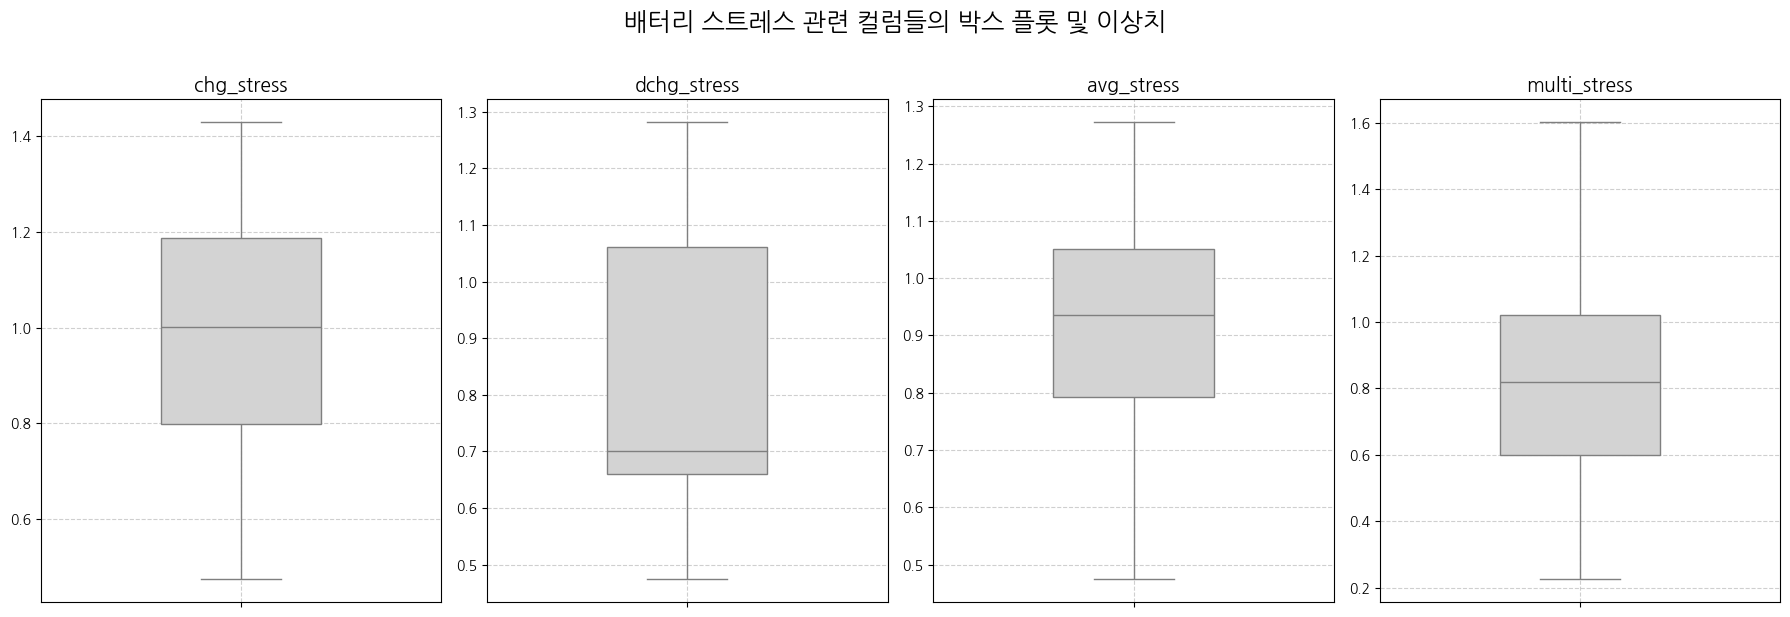

In [25]:
# --- 박스 플롯 그릴 컬럼 리스트 ---
stress_cols = ['chg_stress', 'dchg_stress', 'avg_stress', 'multi_stress']

# --- 박스 플롯 그리기 ---
fig, axes = plt.subplots(1, len(stress_cols), figsize=(len(stress_cols) * 4.5, 6)) # 컬럼 수에 맞춰 그림 크기 설정
fig.suptitle('배터리 스트레스 관련 컬럼들의 박스 플롯 및 이상치', fontsize=18, y=1.02)

for i, col in enumerate(stress_cols):
    sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightgray', width=0.4)
    axes[i].set_title(col, fontsize=14)
    axes[i].set_ylabel('') # y축 레이블은 각 컬럼명으로 대체되므로 비워둠
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

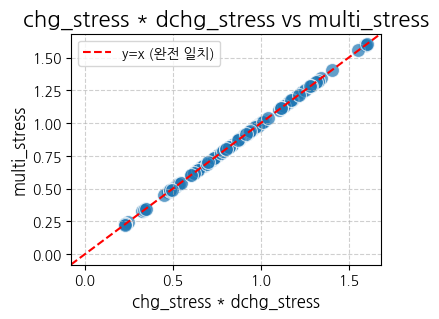

chg_stress * dchg_stress와 multi_stress 간의 상관계수: 1.0000


In [26]:
# --- 1. multi_stress가 chg_stress * dchg_stress와 일치하는지 확인 ---
train_df['chg_dchg_product'] = train_df['chg_stress'] * train_df['dchg_stress']

plt.figure(figsize=(4, 3))
sns.scatterplot(x='chg_dchg_product', y='multi_stress', data=train_df, alpha=0.7, s=100)
plt.title('chg_stress * dchg_stress vs multi_stress', fontsize=16)
plt.xlabel('chg_stress * dchg_stress', fontsize=12)
plt.ylabel('multi_stress', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y=x (완전 일치)') # y=x 라인 추가
plt.legend()
plt.show()

# 상관계수도 확인해보자
correlation = train_df['chg_dchg_product'].corr(train_df['multi_stress'])
print(f"chg_stress * dchg_stress와 multi_stress 간의 상관계수: {correlation:.4f}")

multi_stress와 chg*dchg 가 일치하고, 모두다 이상치는 없어
근데 방전 단계의 스트레스 수치의 분포가 왜이렇게 넓은 걸까?
1. 배터리별 편차
2. 배터리의 어떤 특성을 민감하게 반영하고 있는 걸수도 있음

배터리에 가해지는 스트레스 수치가 높으면 배터리 수명에 영향을 줄것이라고 생각했다.
상관관계를 확인해보자.

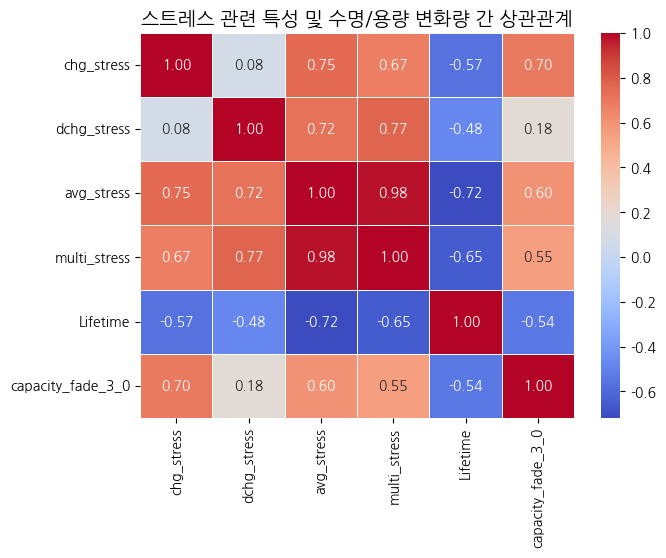

In [27]:

# --- 상관관계를 계산할 컬럼 리스트 ---
features_of_interest = ['chg_stress', 'dchg_stress', 'avg_stress', 'multi_stress', 'Lifetime', 'capacity_fade_3_0']

# --- 상관관계 행렬 계산 ---
correlation_matrix = train_df[features_of_interest].corr()

# --- 히트맵 시각화 ---
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('스트레스 관련 특성 및 수명/용량 변화량 간 상관관계', fontsize=14)
plt.show()


1. chg_stress
: 수명/배터리 용량 변화량과 높은 상관계수를 보여줌 
2. dchg_stress
: 수명/배터리 용량 변화량과 낮은 상관계수를 보여줌
3. avg_stress
: 수명/배터리 용량 변화량과 높은 상관계수를 보여줌
4. multi_stress
수명/배터리 용량 변화량과 높은 상관계수를 보여줌

>> dchg_stress는 낮은 관계성을 보여주는데 왜 multi는 높은 관계성을 보여주는 걸까?
: 방전 스트레스 단독으로는 설명력이 떨어지지만, 충전 스트레스와 함께 작용할 때 비로소 배터리 수명에 유의미한 영향을 미친다는 의미

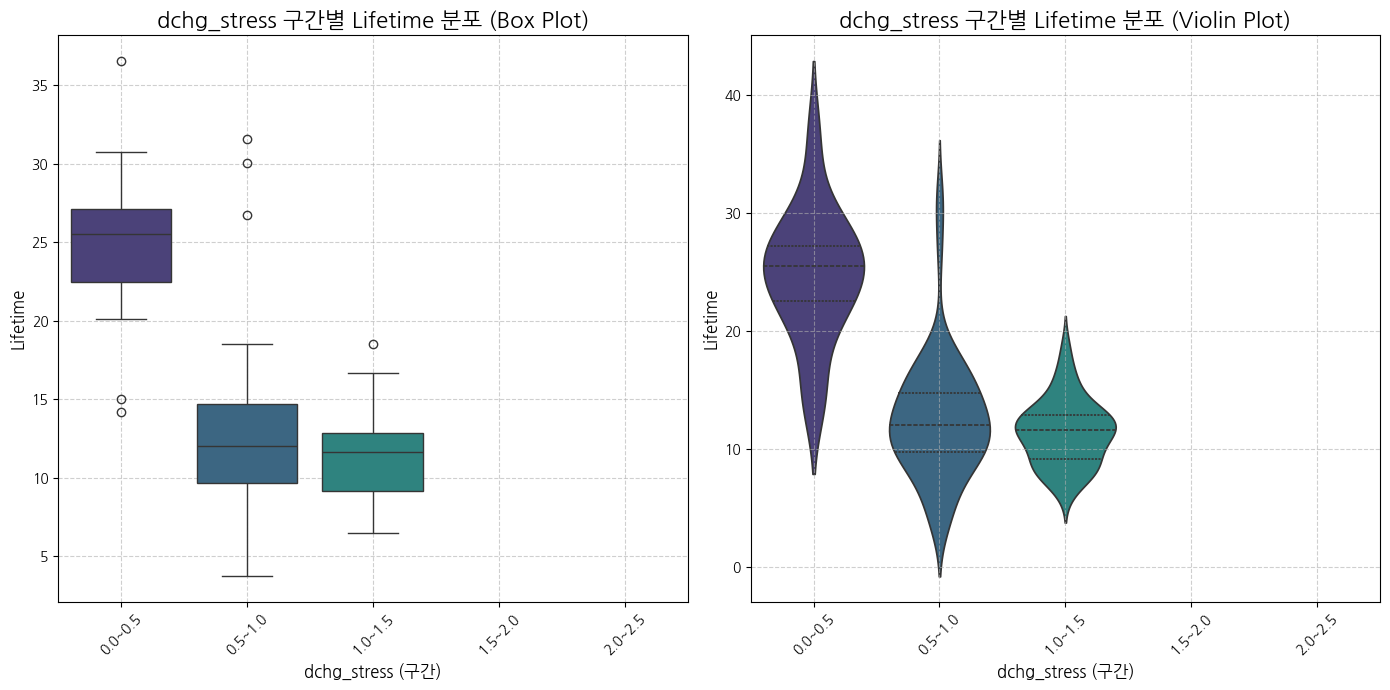

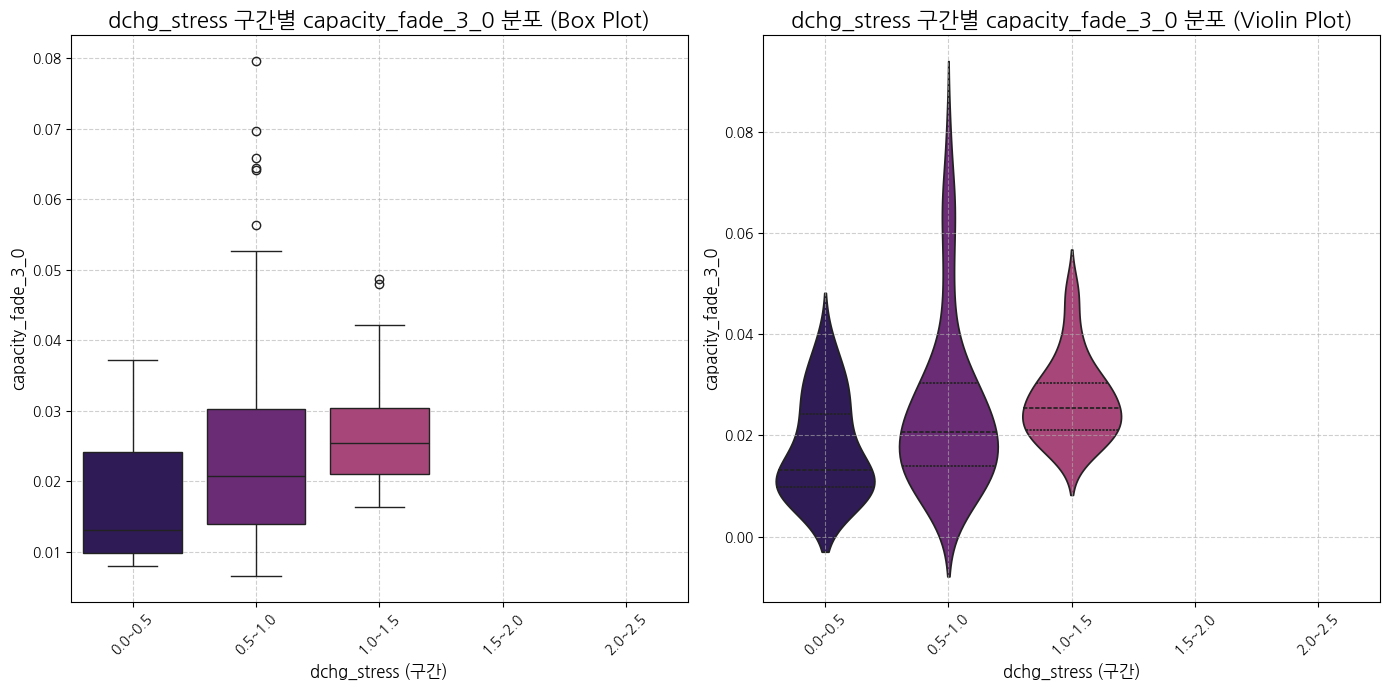

In [28]:
# --- dchg_stress의 비선형적 패턴을 박스 플롯으로 확인 ---

# dchg_stress (구간별) vs Lifetime 분포
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.boxplot(x=pd.cut(train_df['dchg_stress'], bins=bins, labels=labels, right=True, include_lowest=True, ordered=True),
            y='Lifetime', data=train_df, palette='viridis')
plt.title('dchg_stress 구간별 Lifetime 분포 (Box Plot)', fontsize=16)
plt.xlabel('dchg_stress (구간)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.violinplot(x=pd.cut(train_df['dchg_stress'], bins=bins, labels=labels, right=True, include_lowest=True, ordered=True),
               y='Lifetime', data=train_df, inner='quartile', palette='viridis')
plt.title('dchg_stress 구간별 Lifetime 분포 (Violin Plot)', fontsize=16)
plt.xlabel('dchg_stress (구간)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# dchg_stress (구간별) vs capacity_fade_3_0 분포
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.boxplot(x=pd.cut(train_df['dchg_stress'], bins=bins, labels=labels, right=True, include_lowest=True, ordered=True),
            y='capacity_fade_3_0', data=train_df, palette='magma')
plt.title('dchg_stress 구간별 capacity_fade_3_0 분포 (Box Plot)', fontsize=16)
plt.xlabel('dchg_stress (구간)', fontsize=12)
plt.ylabel('capacity_fade_3_0', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.violinplot(x=pd.cut(train_df['dchg_stress'], bins=bins, labels=labels, right=True, include_lowest=True, ordered=True),
               y='capacity_fade_3_0', data=train_df, inner='quartile', palette='magma')
plt.title('dchg_stress 구간별 capacity_fade_3_0 분포 (Violin Plot)', fontsize=16)
plt.xlabel('dchg_stress (구간)', fontsize=12)
plt.ylabel('capacity_fade_3_0', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

dchg_stress의 0.5 구간을 넘어가면 배터리 용량 감소가 심해지고 수명도 줄어듬

비선형적인 패턴이 있음을 확인함. 

In [29]:
# 모든 숫자형 컬럼 선택
numeric_cols = train_df.select_dtypes(include=np.number).columns

# 'dchg_stress'를 제외한 다른 컬럼들과의 상관계수 계산
correlations = train_df[numeric_cols].corr()['dchg_stress'].sort_values(ascending=False).head(10)


# 'dchg_stress' 자기 자신과의 상관계수는 1이므로 제외
correlations = correlations.drop('dchg_stress')

print("--- 'dchg_stress'와 다른 컬럼들 간의 상관계수 ---")
print(correlations)


--- 'dchg_stress'와 다른 컬럼들 간의 상관계수 ---
Dchg_C-rate                0.919432
delta_Q_DVA2               0.783972
multi_stress               0.766061
chg_dchg_product           0.766061
avg_stress                 0.719482
mean_dqdv_dchg_mid_3_0     0.488430
var_dqdv_dchg_high_3_0     0.451461
mean_dqdv_dchg_high_3_0    0.192090
mean_dqdv_dchg_3_0         0.181549
Name: dchg_stress, dtype: float64


방전율과 높은 관련이 있네.. 

방전율 > 방전 스트레스 > 수명에 영향을 준다.

간접적으로 그리고 중요하게 영향을 미치고 잇다.
라고 생각해볼 수도 잇을까?

### 4. DoD & capacity_fade_3_0

DoD가 클수록 배터리의 용량 변화량 > 수명에 미치는 영향이 클 것이라고 생각했다.

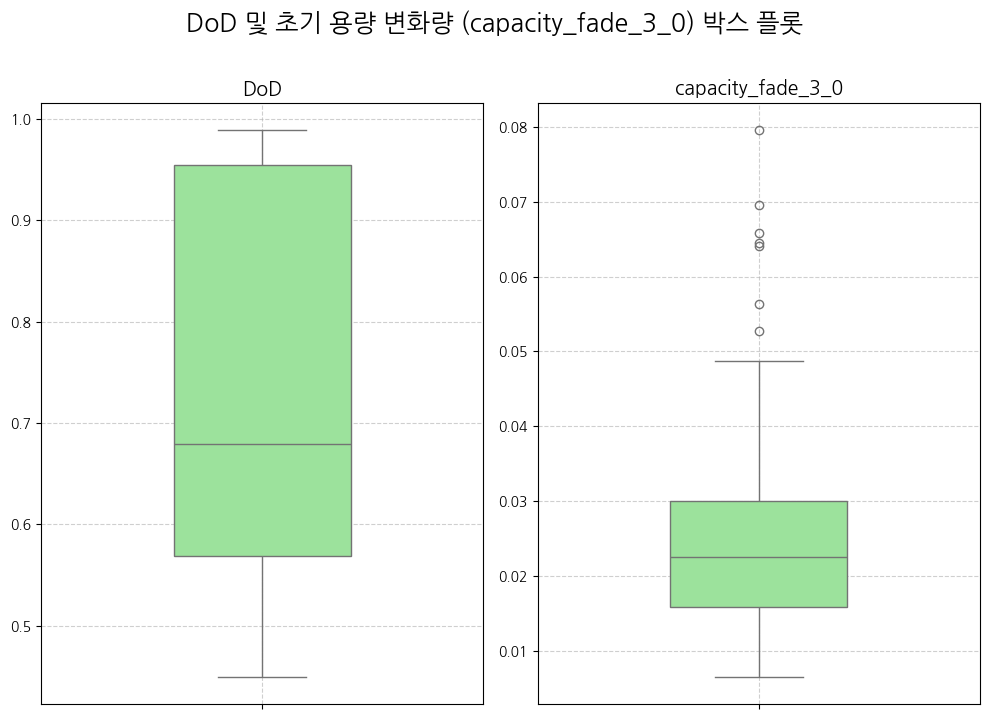


--- DoD 및 capacity_fade_3_0 컬럼의 이상치 비율 ---
'DoD': 0.00%
'capacity_fade_3_0': 6.03%


In [30]:
# --- DoD와 capacity_fade_3_0의 박스 플롯 그리기 ---
cols_to_plot = ['DoD', 'capacity_fade_3_0']

fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(len(cols_to_plot) * 5, 7)) # 1행 2열로 두 개의 서브플롯 생성
fig.suptitle('DoD 및 초기 용량 변화량 (capacity_fade_3_0) 박스 플롯', fontsize=18, y=1.02)

for i, col in enumerate(cols_to_plot):
    if col in train_df.columns:
        sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightgreen', width=0.4)
        axes[i].set_title(col, fontsize=14)
        axes[i].set_ylabel('') # y축 레이블은 각 컬럼명으로 대체되므로 비워둠
        axes[i].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[i].set_title(f"'{col}' 컬럼 없음", fontsize=14)
        axes[i].text(0.5, 0.5, "데이터에 컬럼이 없습니다.", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])


plt.tight_layout() # 서브플롯 간의 간격 자동 조절
plt.show()

# --- 각 컬럼별 이상치 비율도 함께 계산해서 출력 ---
def calculate_outlier_percentage(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    if len(series) == 0:
        return 0
    outlier_percentage = (len(outliers) / len(series)) * 100
    return outlier_percentage

print("\n--- DoD 및 capacity_fade_3_0 컬럼의 이상치 비율 ---")
for col in cols_to_plot:
    if col in train_df.columns:
        percentage = calculate_outlier_percentage(train_df[col].dropna())
        print(f"'{col}': {percentage:.2f}%")
    else:
        print(f"⚠️ 경고: '{col}' 컬럼이 데이터프레임에 없습니다.")

DoD는 이상치가 없지만 capacity는 이상치가 6 %로 무시하긴 어려운 수치라고 판단.

Lifetime과 관련이 깊은 팩터라면 그 때 이상치를 어떻게 처리할지 확인해보기로 한다.

--- DoD와 Lifetime 간의 선형 상관계수: -0.4973 ---

--- DoD와 capacity_fade_3_0 간의 선형 상관계수: 0.0834 ---


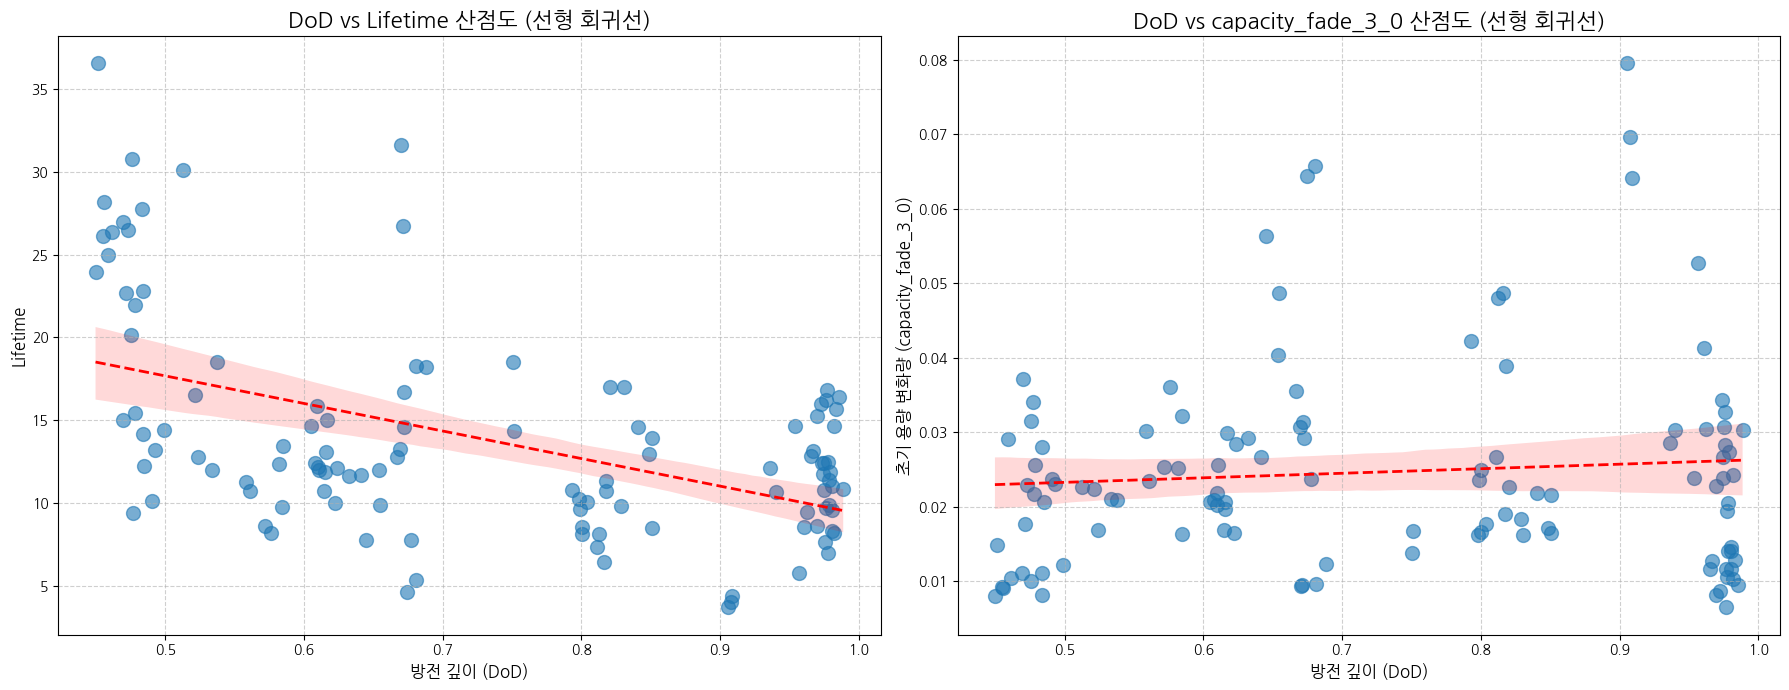

In [31]:
# --- 두 그래프를 하나의 피겨 안에 나란히 그리기 (산점도 + 선형 회귀선만) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1행 2열로 두 개의 서브플롯 생성

# 첫 번째 서브플롯: DoD vs Lifetime
# 1. 상관계수 계산 및 출력 (첫 번째 서브플롯에 해당하는 내용)
correlation_dod_lifetime = train_df['DoD'].corr(train_df['Lifetime'])
print(f"--- DoD와 Lifetime 간의 선형 상관계수: {correlation_dod_lifetime:.4f} ---")

sns.regplot(x='DoD', y='Lifetime', data=train_df.dropna(subset=['DoD', 'Lifetime']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'red', 'linestyle':'--', 'linewidth':2},
            ax=axes[0]) # 첫 번째 축에 그리기
axes[0].set_title('DoD vs Lifetime 산점도 (선형 회귀선)', fontsize=16)
axes[0].set_xlabel('방전 깊이 (DoD)', fontsize=12)
axes[0].set_ylabel('Lifetime', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# 두 번째 서브플롯: DoD vs capacity_fade_3_0
# 1. 상관계수 계산 및 출력 (두 번째 서브플롯에 해당하는 내용)
correlation_dod_fade = train_df['DoD'].corr(train_df['capacity_fade_3_0'])
print(f"\n--- DoD와 capacity_fade_3_0 간의 선형 상관계수: {correlation_dod_fade:.4f} ---")


sns.regplot(x='DoD', y='capacity_fade_3_0', data=train_df.dropna(subset=['DoD', 'capacity_fade_3_0']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'red', 'linestyle':'--', 'linewidth':2},
            ax=axes[1]) # 두 번째 축에 그리기
axes[1].set_title('DoD vs capacity_fade_3_0 산점도 (선형 회귀선)', fontsize=16)
axes[1].set_xlabel('방전 깊이 (DoD)', fontsize=12)
axes[1].set_ylabel('초기 용량 변화량 (capacity_fade_3_0)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout() # 서브플롯 간의 간격 자동 조절
plt.show()

1. DoD vs Lifetime
: 음의 상관성이 높음
2. DoD vs 배터리 용량 변화량
- 상관성이 높을 거라고 생각했는데 상관계수가 낮게 나왔다.
- 하지만 그래프를 보면 값들이 구간별로 뭉쳐져 있다는 느낌을 받을 수가 있는데
비선형적인 패턴이 있는 걸까 ?

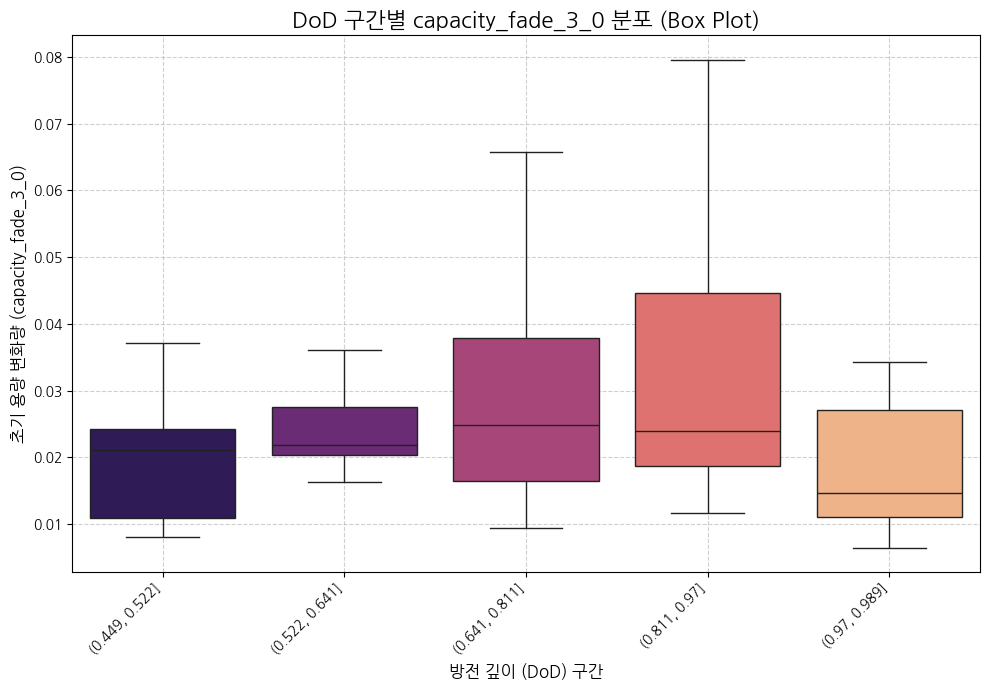

In [32]:
# --- DoD를 구간화하여 capacity_fade_3_0 분포 시각화 (박스 플롯) ---
# 원본 train_df를 복사해서 작업할 데이터프레임 생성
plot_df_dod_binned = train_df.copy()

num_bins = 5 # DoD를 나눌 구간의 개수 설정 (조절 가능)

# DoD 특성을 num_bins 개의 동일 빈도로 구간화 (qcut 사용)
# duplicates='drop'을 사용하여 동일한 경계값이 발생하면 처리
try:
    plot_df_dod_binned['DoD_bin'] = pd.qcut(
        plot_df_dod_binned['DoD'], q=num_bins, duplicates='drop'
    )
except ValueError as e:
    # qcut으로 나눌 수 없는 경우 (예: 데이터가 너무 적거나, 값이 모두 같거나)
    print(f"⚠️ DoD 컬럼을 {num_bins}개 구간으로 나누는 데 실패했습니다. (오류: {e})")
    print(f"  DoD의 고유 값 개수: {plot_df_dod_binned['DoD'].nunique()}")
    # 대체 방법: 균등 간격으로 나누거나, 다음 특성으로 넘어감
    plot_df_dod_binned['DoD_bin'] = pd.cut(
        plot_df_dod_binned['DoD'], bins=num_bins, include_lowest=True
    )
    print(f"  대신 DoD를 {num_bins}개 균등 간격으로 나누어 시도합니다.")

plt.figure(figsize=(10, 7))
sns.boxplot(x='DoD_bin', y='capacity_fade_3_0',
            data=plot_df_dod_binned.dropna(subset=['DoD_bin', 'capacity_fade_3_0']),
            palette='magma', # 색상 팔레트 변경
            showfliers=True) # 이상치(outliers) 표시 여부

plt.title('DoD 구간별 capacity_fade_3_0 분포 (Box Plot)', fontsize=16)
plt.xlabel('방전 깊이 (DoD) 구간', fontsize=12)
plt.ylabel('초기 용량 변화량 (capacity_fade_3_0)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right') # x축 레이블 회전 및 정렬
plt.tight_layout()
plt.show()


비선형적인 패턴이 있는지 잘 모르겟다..

--- capacity_fade_3_0와 Lifetime 간의 분석 ---
  선형 상관계수: -0.5420


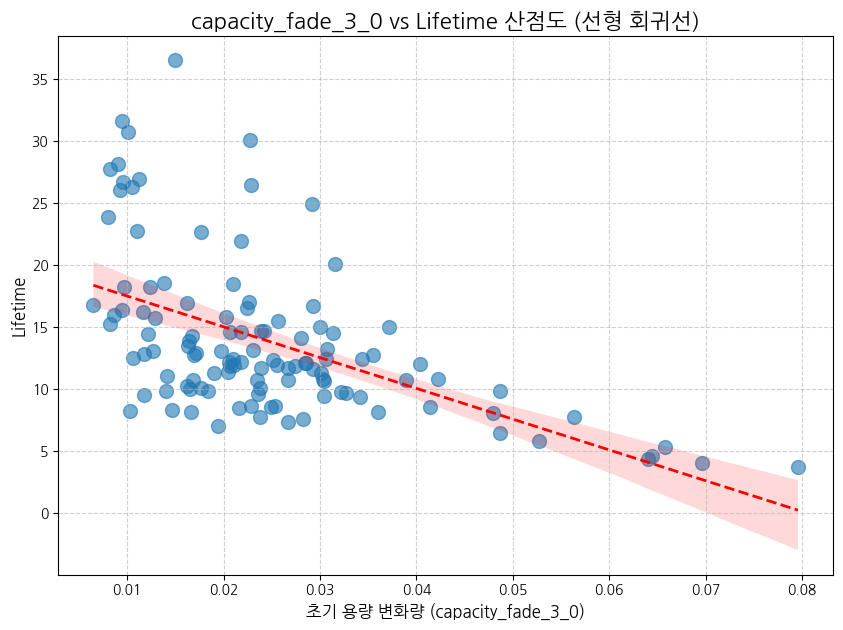

In [33]:
# --- capacity_fade_3_0와 Lifetime 간의 상관관계 및 시각화 ---

print("--- capacity_fade_3_0와 Lifetime 간의 분석 ---")
# 1. 상관계수 계산 및 출력
correlation_fade_lifetime = train_df['capacity_fade_3_0'].corr(train_df['Lifetime'])
print(f"  선형 상관계수: {correlation_fade_lifetime:.4f}")

# 2. 산점도에 선형 회귀선 그리기
plt.figure(figsize=(10, 7))
sns.regplot(x='capacity_fade_3_0', y='Lifetime', data=train_df.dropna(subset=['capacity_fade_3_0', 'Lifetime']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'red', 'linestyle':'--', 'linewidth':2})
plt.title('capacity_fade_3_0 vs Lifetime 산점도 (선형 회귀선)', fontsize=16)
plt.xlabel('초기 용량 변화량 (capacity_fade_3_0)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

데이터가 전체적으로 비선형적인 패턴을 보이는 관계가 많아서 트리 기반 모델로 처리할 예정이라 일단 해당 이상치는 처리하지 않고 놔둔다

### 5. delta_Q_DVA

--- 요청된 컬럼들의 이상치 비율 ---
'delta_Q_DVA1': 6.03%
'delta_Q_DVA2': 0.00%
'delta_Q_DVA3': 6.03%
'delta_Q_DVA4': 0.86%


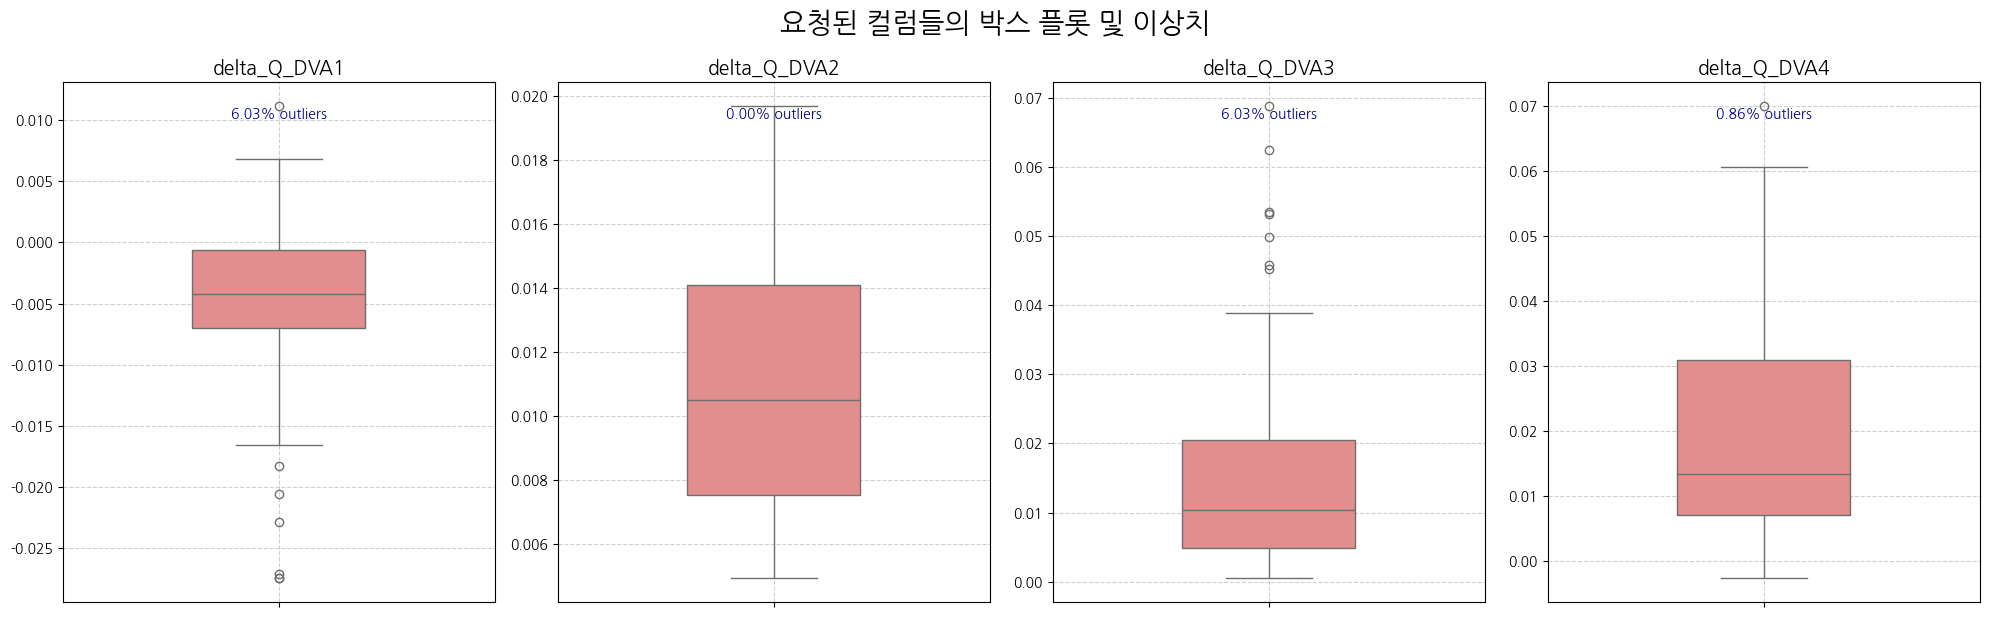

In [34]:
# --- 박스 플롯 그릴 컬럼 리스트 ---
# 네가 요청한 모든 컬럼 포함
cols_to_check_for_outliers = [
    'delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4',
]

# --- 각 컬럼별 이상치 비율 계산 및 출력 ---
print("--- 요청된 컬럼들의 이상치 비율 ---")
outlier_percentages = {}
for col in cols_to_check_for_outliers:
    if col in train_df.columns:
        percentage = calculate_outlier_percentage(train_df[col].dropna())
        outlier_percentages[col] = percentage
        print(f"'{col}': {percentage:.2f}%")
    else:
        print(f"⚠️ 경고: '{col}' 컬럼이 데이터프레임에 없습니다. (이름 확인 필요)")
        outlier_percentages[col] = np.nan # NaN으로 표시

# --- 박스 플롯 그리기 ---
# 서브플롯 개수 계산 (한 줄에 최대 4개 그래프)
n_cols = len(cols_to_check_for_outliers)
n_rows = (n_cols + 3) // 4 # 필요한 행 수 계산 (올림)

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 6))
axes = axes.flatten() # 2D 배열을 1D로 평탄화하여 반복문에서 사용 용이하게 함

fig.suptitle('요청된 컬럼들의 박스 플롯 및 이상치', fontsize=20, y=1.02) # 전체 제목

for i, col in enumerate(cols_to_check_for_outliers):
    if col in train_df.columns:
        sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightcoral', width=0.4)
        axes[i].set_title(col, fontsize=14)
        axes[i].set_ylabel('')
        axes[i].grid(True, linestyle='--', alpha=0.6)
        # 이상치 비율을 그래프 제목 아래에 표시
        if col in outlier_percentages and not np.isnan(outlier_percentages[col]):
            axes[i].text(0.5, 0.95, f'{outlier_percentages[col]:.2f}% outliers',
                         transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='darkblue')
    else:
        axes[i].set_title(f"'{col}' 컬럼 없음", fontsize=14, color='red')
        axes[i].text(0.5, 0.5, "데이터에 컬럼이 없습니다.", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, color='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# 남는 서브플롯 공간은 숨기기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9) # 전체 제목이 잘리지 않도록 조정
plt.show()

트리모델을 쓴다는 가정하에 무시할 수준은 아니지만 그렇다고 반드시 제거가 필요한 수준은 아닌 것 같다.

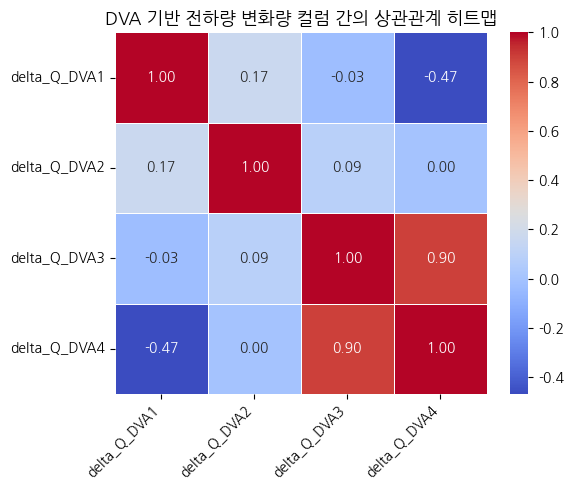

In [35]:
# --- delta_Q_DVA 컬럼들 간의 상관 행렬 및 히트맵 ---
dva_cols_to_correlate = ['delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4']
correlation_matrix = train_df[dva_cols_to_correlate].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('DVA 기반 전하량 변화량 컬럼 간의 상관관계 히트맵', fontsize=13)
plt.xticks(rotation=45, ha='right') # x축 레이블 회전
plt.yticks(rotation=0) # y축 레이블 회전
plt.tight_layout()
plt.show()


3,4가 다중공선성을 신경써야할 수준으로 강력하게 연결되어있네.. 

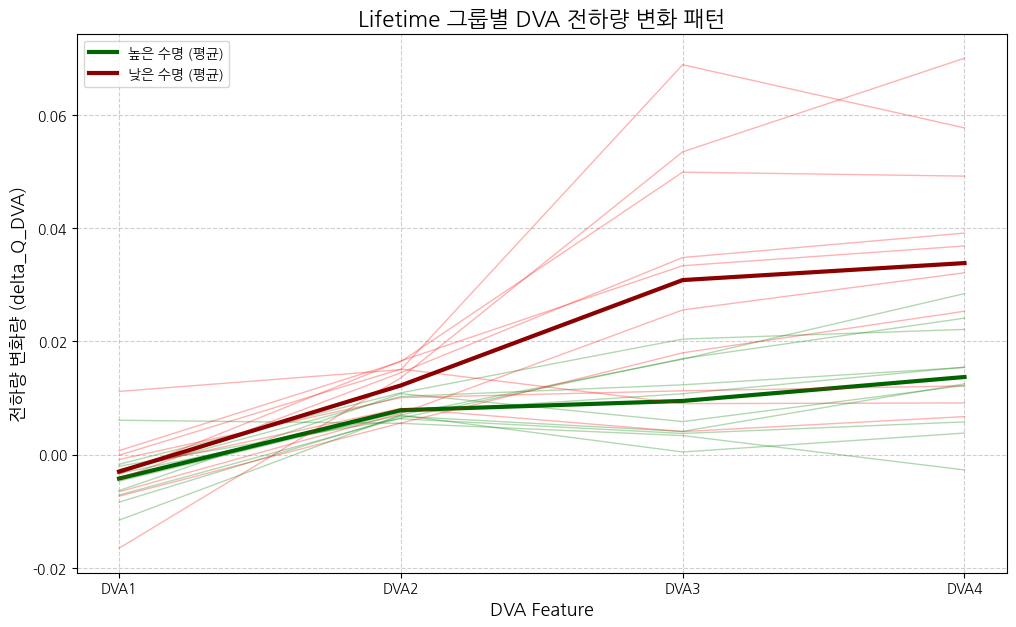

In [36]:
# --- Lifetime 기준으로 그룹 나누기 ---
# 예시로 Lifetime 상위 25%와 하위 25%를 나누어 'High Lifetime'과 'Low Lifetime' 그룹으로 정의
# 실제 데이터의 분포를 보고 이 임계값을 조정해야 함
lifetime_threshold_high = train_df['Lifetime'].quantile(0.75) # 상위 25% 이상
lifetime_threshold_low = train_df['Lifetime'].quantile(0.25)  # 하위 25% 이하

high_lifetime_batteries = train_df[train_df['Lifetime'] >= lifetime_threshold_high].head(10) # 상위 10개 샘플
low_lifetime_batteries = train_df[train_df['Lifetime'] <= lifetime_threshold_low].head(10)   # 하위 10개 샘플

# DVA 컬럼 목록
dva_cols = ['delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4']
dva_labels = ['DVA1', 'DVA2', 'DVA3', 'DVA4'] # X축 레이블을 위한 리스트

plt.figure(figsize=(12, 7))
plt.title('Lifetime 그룹별 DVA 전하량 변화 패턴', fontsize=16)
plt.xlabel('DVA Feature', fontsize=13)
plt.ylabel('전하량 변화량 (delta_Q_DVA)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(len(dva_labels)), labels=dva_labels) # X축 레이블 설정

# High Lifetime 그룹 패턴 그리기
for idx, row in high_lifetime_batteries.iterrows():
    plt.plot(dva_labels, row[dva_cols], color='green', alpha=0.3, linewidth=1)
# High Lifetime 그룹 평균 패턴
plt.plot(dva_labels, high_lifetime_batteries[dva_cols].mean(), color='darkgreen', linewidth=3, label='높은 수명 (평균)')

# Low Lifetime 그룹 패턴 그리기
for idx, row in low_lifetime_batteries.iterrows():
    plt.plot(dva_labels, row[dva_cols], color='red', alpha=0.3, linewidth=1)
# Low Lifetime 그룹 평균 패턴
plt.plot(dva_labels, low_lifetime_batteries[dva_cols].mean(), color='darkred', linewidth=3, label='낮은 수명 (평균)')

plt.legend()
plt.show()


배터리 수명이 긴 애들(초록) VS 수명이 짧은 애들(빨간)
진한선:평균, 옅은 선: 각각

DVA1, DVA2, DV3, DVA4: 전기를 충전하거나 방전할때 배터리 안에서 중요한 반응이 일어나는 위치

0에 가까우면: 거의 안 바뀜,
0에서 멀어지면: 많이 바뀜

> 수명이 짧은 배터리는 안에서 전기 저장량이 훨씬 많이 변햇어, 많이 손상되었어
배터리 수명을 예측하려면 DVA3, DVA4에서의 변화량이 핵심이구나! 

DVA_Slope_3_4 (DVA3에서 DVA4로의 변화량) 변수 생성:

DVA4 - DVA3 로 계산하는 거야.

이 변수는 Lifetime이 낮은 배터리에서 더 큰 양수 값을 가질 것이고, 높은 배터리에서는 작거나 음수 값을 가질 가능성이 높아. 즉, Lifetime과 강한 음의 상관관계를 보일 것으로 예상돼.

이 변수 하나만으로도 Lifetime을 예측하는 데 큰 기여를 할 수 있을 거야.

DVA_Overall_Change (DVA1에서 DVA4로의 전체 변화량) 변수 생성:

DVA4 - DVA1 로 계산하는 거야.

이 변수는 DVA 패턴의 전체적인 폭을 나타내. 마찬가지로 Lifetime이 낮은 배터리에서 더 큰 값을 가질 가능성이 높지.


--- 각 컬럼과 Lifetime 간의 선형 상관계수 ---
'delta_Q_DVA3': -0.4630
'delta_Q_DVA2': -0.4331
'delta_Q_DVA4': -0.3681
'delta_Q_DVA1': -0.0936


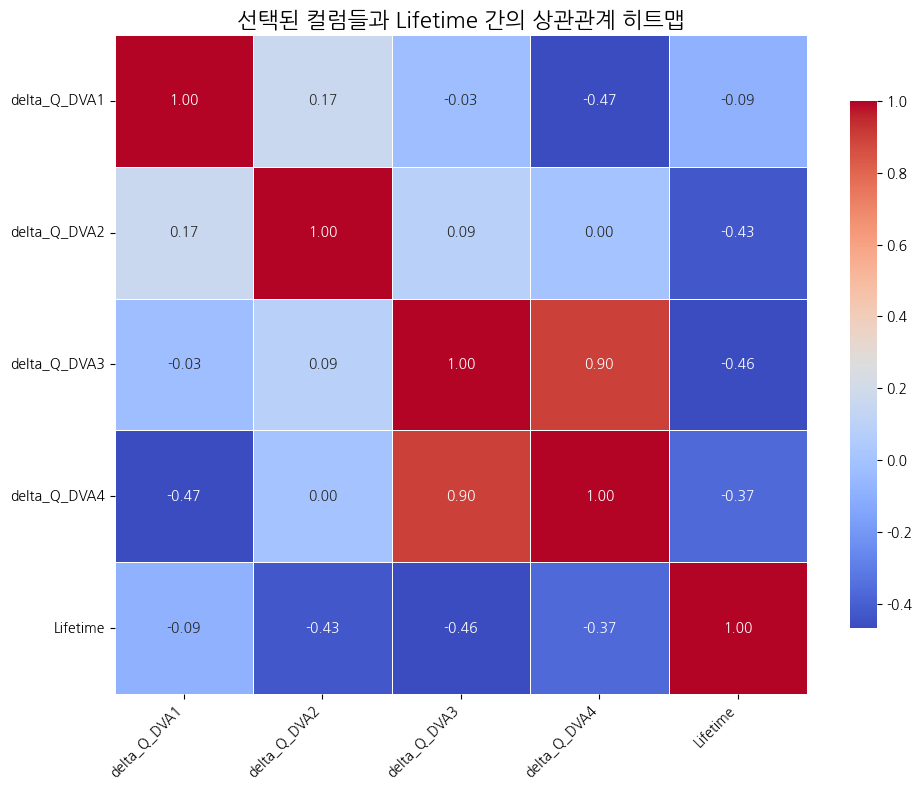

In [37]:
# Lifetime과 상관관계를 확인할 컬럼 리스트
target_cols = [
    'delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4',
    'Lifetime' # Lifetime도 포함시켜서 자기 자신과의 상관관계를 1로 보여주게 함
]

# 실제로 데이터프레임에 존재하는 컬럼만 필터링
existing_cols = [col for col in target_cols if col in train_df.columns]

if not existing_cols:
    print("⚠️ 경고: 분석할 수 있는 유효한 컬럼이 없습니다. 데이터프레임에 컬럼이 있는지 확인해주세요.")
else:
    # 상관계수 계산
    correlation_matrix = train_df[existing_cols].corr()

    # Lifetime과의 상관계수만 추출하여 출력
    print("--- 각 컬럼과 Lifetime 간의 선형 상관계수 ---")
    if 'Lifetime' in correlation_matrix.columns:
        # Lifetime과의 상관계수를 절대값 기준으로 정렬하여 보기 좋게 출력
        lifetime_correlations = correlation_matrix['Lifetime'].drop('Lifetime') # Lifetime 자기 자신은 제외
        
        # 상관계수 값을 보기 쉽게 표현
        formatted_correlations = {k: f"{v:.4f}" for k, v in lifetime_correlations.items()}
        
        # 상관계수가 높은(절대값 기준) 순서대로 정렬하여 출력
        sorted_correlations = sorted(formatted_correlations.items(), key=lambda item: abs(float(item[1])), reverse=True)
        for col, corr_val in sorted_correlations:
            print(f"'{col}': {corr_val}")
    else:
        print("Lifetime 컬럼이 데이터프레임에 없습니다.")

    # 히트맵 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('선택된 컬럼들과 Lifetime 간의 상관관계 히트맵', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### 5. mean_dqdv_dchg_3_0 & var_dqdv_dchg_3_0

--- 요청된 컬럼들의 이상치 비율 ---
'mean_dqdv_dchg_3_0': 6.03%
'var_dqdv_dchg_3_0': 2.59%


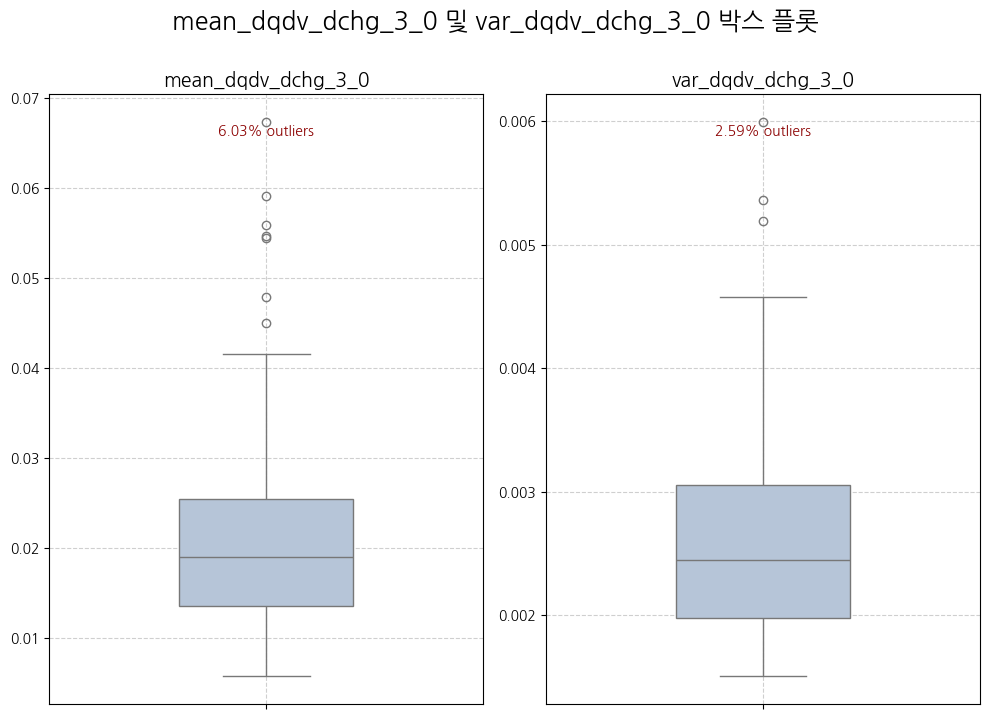

In [38]:
# --- 박스 플롯 그릴 컬럼 리스트 ---
cols_to_check_for_outliers = ['mean_dqdv_dchg_3_0', 'var_dqdv_dchg_3_0']

# --- 각 컬럼별 이상치 비율 계산 및 출력 ---
print("--- 요청된 컬럼들의 이상치 비율 ---")
outlier_percentages = {}
for col in cols_to_check_for_outliers:
    if col in train_df.columns:
        percentage = calculate_outlier_percentage(train_df[col].dropna())
        outlier_percentages[col] = percentage
        print(f"'{col}': {percentage:.2f}%")
    else:
        print(f"⚠️ 경고: '{col}' 컬럼이 데이터프레임에 없습니다. (이름 확인 필요)")
        outlier_percentages[col] = np.nan # NaN으로 표시

# --- 박스 플롯 그리기 ---
fig, axes = plt.subplots(1, len(cols_to_check_for_outliers), figsize=(len(cols_to_check_for_outliers) * 5, 7)) # 1행 2열
fig.suptitle('mean_dqdv_dchg_3_0 및 var_dqdv_dchg_3_0 박스 플롯', fontsize=18, y=1.02)

# axes가 하나만 있을 경우 (컬럼이 1개일 경우)를 대비하여 리스트로 감싸거나 flatten 처리
if len(cols_to_check_for_outliers) == 1:
    axes = [axes]

for i, col in enumerate(cols_to_check_for_outliers):
    if col in train_df.columns:
        sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightsteelblue', width=0.4)
        axes[i].set_title(col, fontsize=14)
        axes[i].set_ylabel('')
        axes[i].grid(True, linestyle='--', alpha=0.6)
        # 이상치 비율을 그래프 제목 아래에 표시
        if col in outlier_percentages and not np.isnan(outlier_percentages[col]):
            axes[i].text(0.5, 0.95, f'{outlier_percentages[col]:.2f}% outliers',
                         transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='darkred')
    else:
        axes[i].set_title(f"'{col}' 컬럼 없음", fontsize=14, color='red')
        axes[i].text(0.5, 0.5, "데이터에 컬럼이 없습니다.", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, color='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout() # 서브플롯 간의 간격 자동 조절
plt.subplots_adjust(top=0.9) # 전체 제목이 잘리지 않도록 조정
plt.show()


얘도 일단 무시할게

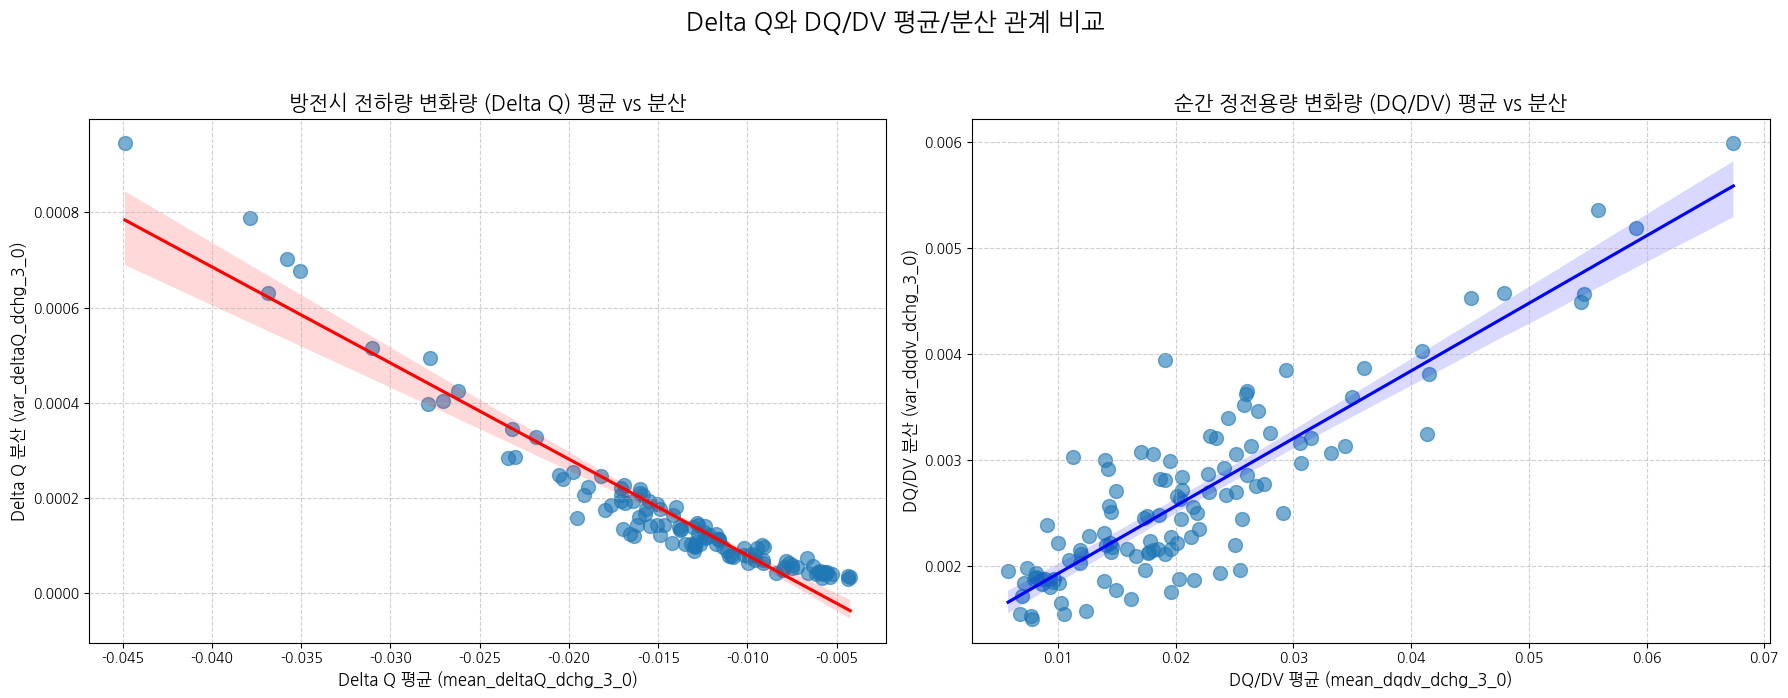

--- 방전시 전하량 변화량 (Delta Q) 평균과 분산 간의 상관계수: -0.9597 ---
--- 순간 정전용량 변화량 (DQ/DV) 평균과 분산 간의 상관계수: 0.8809 ---


In [39]:
# --- 두 개의 서브플롯으로 산점도 그리기 (순서 변경!) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1행 2열의 서브플롯 생성

# 첫 번째 서브플롯 (왼쪽): 방전시 전하량 변화량 (Delta Q) 평균 vs 분산
sns.regplot(x='mean_deltaQ_dchg_3_0', y='var_deltaQ_dchg_3_0',
            data=train_df.dropna(subset=['mean_deltaQ_dchg_3_0', 'var_deltaQ_dchg_3_0']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'red'}, # 색상 유지
            ax=axes[0]) # 첫 번째 축 (왼쪽)에 그리기
axes[0].set_title('방전시 전하량 변화량 (Delta Q) 평균 vs 분산', fontsize=15)
axes[0].set_xlabel('Delta Q 평균 (mean_deltaQ_dchg_3_0)', fontsize=12)
axes[0].set_ylabel('Delta Q 분산 (var_deltaQ_dchg_3_0)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# 두 번째 서브플롯 (오른쪽): 순간 정전용량 변화량 (DQ/DV) 평균 vs 분산
sns.regplot(x='mean_dqdv_dchg_3_0', y='var_dqdv_dchg_3_0',
            data=train_df.dropna(subset=['mean_dqdv_dchg_3_0', 'var_dqdv_dchg_3_0']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'blue'}, # 색상 유지
            ax=axes[1]) # 두 번째 축 (오른쪽)에 그리기
axes[1].set_title('순간 정전용량 변화량 (DQ/DV) 평균 vs 분산', fontsize=15)
axes[1].set_xlabel('DQ/DV 평균 (mean_dqdv_dchg_3_0)', fontsize=12)
axes[1].set_ylabel('DQ/DV 분산 (var_dqdv_dchg_3_0)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Delta Q와 DQ/DV 평균/분산 관계 비교', fontsize=18, y=1.02) # 전체 타이틀
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 그래프 간 간격 및 전체 타이틀 공간 조절
plt.show()

# --- 각 쌍의 상관계수 출력 ---
corr_deltaQ = train_df['mean_deltaQ_dchg_3_0'].corr(train_df['var_deltaQ_dchg_3_0'])
corr_dqdv = train_df['mean_dqdv_dchg_3_0'].corr(train_df['var_dqdv_dchg_3_0'])


print(f"--- 방전시 전하량 변화량 (Delta Q) 평균과 분산 간의 상관계수: {corr_deltaQ:.4f} ---")
print(f"--- 순간 정전용량 변화량 (DQ/DV) 평균과 분산 간의 상관계수: {corr_dqdv:.4f} ---")

건강상태를 나타내는 지표일 수 잇으니 capacity_fade_와의 관계를 보는 것도 중요 

--- 각 컬럼과 Lifetime, capacity_fade_3_0 간의 선형 상관계수 ---

▶️ Lifetime과의 상관관계:
  'mean_dqdv_dchg_3_0': -0.5432
  'var_dqdv_dchg_3_0': -0.5231

▶️ capacity_fade_3_0과의 상관관계:
  'mean_dqdv_dchg_3_0': 0.9999
  'var_dqdv_dchg_3_0': 0.8798


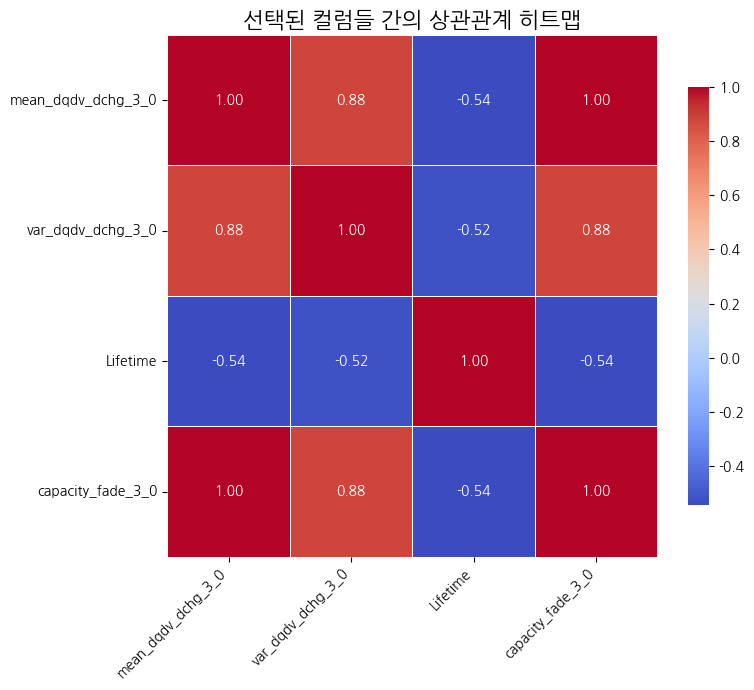

In [40]:
# 상관관계를 확인할 컬럼 리스트
target_cols = [
    'mean_dqdv_dchg_3_0',
    'var_dqdv_dchg_3_0',
    'Lifetime',
    'capacity_fade_3_0'
]

# 실제로 데이터프레임에 존재하는 컬럼만 필터링
existing_cols = [col for col in target_cols if col in train_df.columns]

if len(existing_cols) < 2: # 최소 2개 이상의 컬럼이 있어야 상관계수 계산 가능
    print("⚠️ 경고: 분석할 수 있는 유효한 컬럼이 부족합니다. 데이터프레임에 필요한 컬럼이 있는지 확인해주세요.")
else:
    # 상관계수 계산
    correlation_matrix = train_df[existing_cols].corr()

    # Lifetime 및 capacity_fade_3_0과의 상관계수만 추출하여 출력
    print("--- 각 컬럼과 Lifetime, capacity_fade_3_0 간의 선형 상관계수 ---")
    
    # Lifetime과의 상관관계
    if 'Lifetime' in correlation_matrix.columns:
        lifetime_correlations = correlation_matrix['Lifetime'].drop('Lifetime')
        if 'capacity_fade_3_0' in lifetime_correlations.index:
            lifetime_correlations = lifetime_correlations.drop('capacity_fade_3_0') # capacity_fade_3_0은 따로 표시
        
        print("\n▶️ Lifetime과의 상관관계:")
        if not lifetime_correlations.empty:
            sorted_lifetime_corrs = sorted(lifetime_correlations.items(), key=lambda item: abs(float(item[1])), reverse=True)
            for col, corr_val in sorted_lifetime_corrs:
                print(f"  '{col}': {corr_val:.4f}")
        else:
            print("  Lifetime과 상관관계를 볼 수 있는 다른 컬럼이 없습니다.")
    else:
        print("Lifetime 컬럼이 데이터프레임에 없습니다.")

    # capacity_fade_3_0과의 상관관계
    if 'capacity_fade_3_0' in correlation_matrix.columns:
        capacity_fade_correlations = correlation_matrix['capacity_fade_3_0'].drop('capacity_fade_3_0')
        if 'Lifetime' in capacity_fade_correlations.index:
            capacity_fade_correlations = capacity_fade_correlations.drop('Lifetime') # Lifetime은 따로 표시
        
        print("\n▶️ capacity_fade_3_0과의 상관관계:")
        if not capacity_fade_correlations.empty:
            sorted_fade_corrs = sorted(capacity_fade_correlations.items(), key=lambda item: abs(float(item[1])), reverse=True)
            for col, corr_val in sorted_fade_corrs:
                print(f"  '{col}': {corr_val:.4f}")
        else:
            print("  capacity_fade_3_0과 상관관계를 볼 수 있는 다른 컬럼이 없습니다.")
    else:
        print("capacity_fade_3_0 컬럼이 데이터프레임에 없습니다.")


    # 히트맵 시각화
    plt.figure(figsize=(8, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('선택된 컬럼들 간의 상관관계 히트맵', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### 7. mean_dqdv_dchg_3_0 & var_dqdv_dchg_3_0

--- 요청된 컬럼들의 이상치 비율 ---
'mean_dqdv_dchg_3_0': 6.03%
'var_dqdv_dchg_3_0': 2.59%


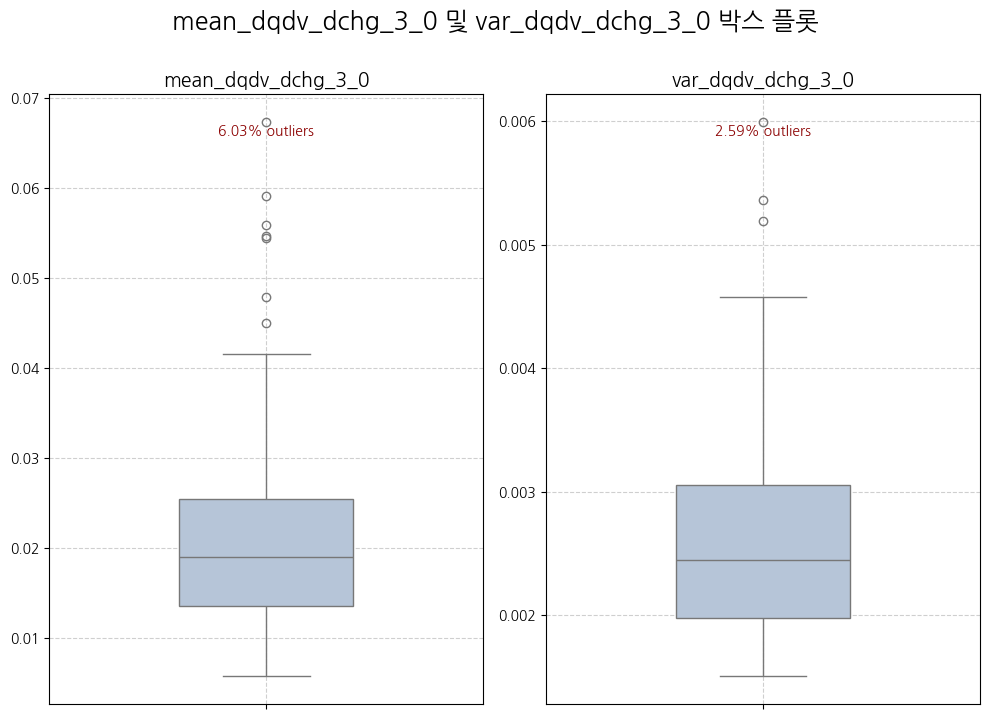

In [41]:
# --- 박스 플롯 그릴 컬럼 리스트 ---
cols_to_check_for_outliers = ['mean_dqdv_dchg_3_0', 'var_dqdv_dchg_3_0']

# --- 각 컬럼별 이상치 비율 계산 및 출력 ---
print("--- 요청된 컬럼들의 이상치 비율 ---")
outlier_percentages = {}
for col in cols_to_check_for_outliers:
    if col in train_df.columns:
        percentage = calculate_outlier_percentage(train_df[col].dropna())
        outlier_percentages[col] = percentage
        print(f"'{col}': {percentage:.2f}%")
    else:
        print(f"⚠️ 경고: '{col}' 컬럼이 데이터프레임에 없습니다. (이름 확인 필요)")
        outlier_percentages[col] = np.nan # NaN으로 표시

# --- 박스 플롯 그리기 ---
fig, axes = plt.subplots(1, len(cols_to_check_for_outliers), figsize=(len(cols_to_check_for_outliers) * 5, 7)) # 1행 2열
fig.suptitle('mean_dqdv_dchg_3_0 및 var_dqdv_dchg_3_0 박스 플롯', fontsize=18, y=1.02)

# axes가 하나만 있을 경우 (컬럼이 1개일 경우)를 대비하여 리스트로 감싸거나 flatten 처리
if len(cols_to_check_for_outliers) == 1:
    axes = [axes]

for i, col in enumerate(cols_to_check_for_outliers):
    if col in train_df.columns:
        sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightsteelblue', width=0.4)
        axes[i].set_title(col, fontsize=14)
        axes[i].set_ylabel('')
        axes[i].grid(True, linestyle='--', alpha=0.6)
        # 이상치 비율을 그래프 제목 아래에 표시
        if col in outlier_percentages and not np.isnan(outlier_percentages[col]):
            axes[i].text(0.5, 0.95, f'{outlier_percentages[col]:.2f}% outliers',
                         transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='darkred')
    else:
        axes[i].set_title(f"'{col}' 컬럼 없음", fontsize=14, color='red')
        axes[i].text(0.5, 0.5, "데이터에 컬럼이 없습니다.", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, color='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout() # 서브플롯 간의 간격 자동 조절
plt.subplots_adjust(top=0.9) # 전체 제목이 잘리지 않도록 조정
plt.show()

--- mean_dqdv_dchg_3_0와 var_dqdv_dchg_3_0 간의 상관관계 ---
'mean_dqdv_dchg_3_0'와 'var_dqdv_dchg_3_0' 간의 선형 상관계수: 0.8809


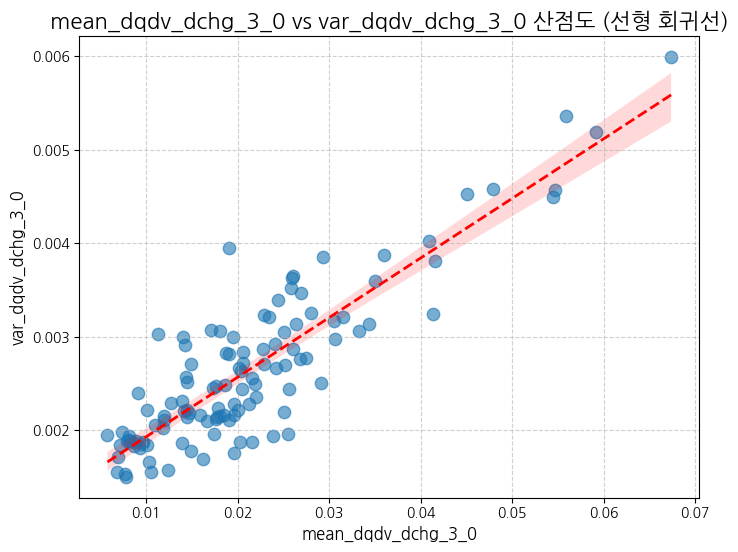

In [42]:
# --- mean_dqdv_dchg_3_0와 var_dqdv_dchg_3_0 간의 상관계수 계산 및 출력 ---

print("--- mean_dqdv_dchg_3_0와 var_dqdv_dchg_3_0 간의 상관관계 ---")

col1 = 'mean_dqdv_dchg_3_0'
col2 = 'var_dqdv_dchg_3_0'

if col1 in train_df.columns and col2 in train_df.columns:
    # 결측치(NaN)가 있으면 상관계수 계산에 문제가 생길 수 있으므로, 해당 컬럼들에서 결측치가 없는 행만 선택
    temp_df = train_df[[col1, col2]].dropna()
    
    if not temp_df.empty:
        correlation = temp_df[col1].corr(temp_df[col2])
        print(f"'{col1}'와 '{col2}' 간의 선형 상관계수: {correlation:.4f}")

        # 산점도 시각화
        plt.figure(figsize=(8, 6))
        sns.regplot(x=col1, y=col2, data=temp_df,
                    scatter_kws={'alpha':0.6, 's':80},
                    line_kws={'color':'red', 'linestyle':'--', 'linewidth':2})
        plt.title(f'{col1} vs {col2} 산점도 (선형 회귀선)', fontsize=16)
        plt.xlabel(col1, fontsize=12)
        plt.ylabel(col2, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    else:
        print(f"⚠️ 경고: '{col1}' 또는 '{col2}' 컬럼에 유효한 데이터가 부족하여 상관계수를 계산할 수 없습니다.")
else:
    missing_cols = [c for c in [col1, col2] if c not in train_df.columns]
    print(f"⚠️ 경고: 다음 컬럼들이 데이터프레임에 없습니다: {missing_cols}. 컬럼 이름을 확인해주세요.")


--- 각 컬럼과 Lifetime 간의 선형 상관계수 ---
  'mean_dqdv_dchg_3_0': -0.5432
  'var_dqdv_dchg_3_0': -0.5231


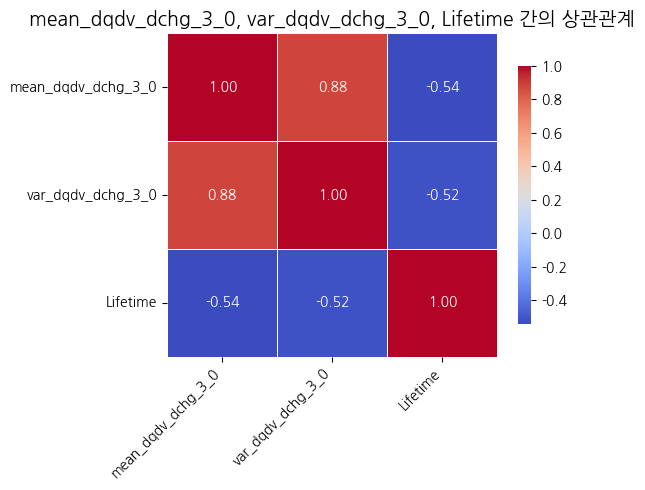

In [43]:
# 상관관계를 확인할 컬럼 리스트
target_cols = [
    'mean_dqdv_dchg_3_0',
    'var_dqdv_dchg_3_0',
    'Lifetime'
]

# 실제로 데이터프레임에 존재하는 컬럼만 필터링
existing_cols = [col for col in target_cols if col in train_df.columns]

if len(existing_cols) < 2: # 최소 2개 이상의 컬럼이 있어야 상관계수 계산 가능
    print("⚠️ 경고: 분석할 수 있는 유효한 컬럼이 부족합니다. 데이터프레임에 필요한 컬럼이 있는지 확인해주세요.")
else:
    # 상관계수 계산
    correlation_matrix = train_df[existing_cols].corr()

    # Lifetime과의 상관계수만 추출하여 출력
    print("--- 각 컬럼과 Lifetime 간의 선형 상관계수 ---")
    
    if 'Lifetime' in correlation_matrix.columns:
        # Lifetime 본인은 제외
        lifetime_correlations = correlation_matrix['Lifetime'].drop('Lifetime')
        
        if not lifetime_correlations.empty:
            # 상관계수 값을 보기 쉽게 표현
            formatted_correlations = {k: f"{v:.4f}" for k, v in lifetime_correlations.items()}
            
            # 상관계수가 높은(절대값 기준) 순서대로 정렬하여 출력
            sorted_correlations = sorted(formatted_correlations.items(), key=lambda item: abs(float(item[1])), reverse=True)
            for col, corr_val in sorted_correlations:
                print(f"  '{col}': {corr_val}")
        else:
            print("  Lifetime과 상관관계를 볼 수 있는 다른 컬럼이 없습니다.")
    else:
        print("Lifetime 컬럼이 데이터프레임에 없습니다.")

    # 히트맵 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('mean_dqdv_dchg_3_0, var_dqdv_dchg_3_0, Lifetime 간의 상관관계', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### mean_dqdv_dchg_high_3_0' & 'var_dqdv_dchg_high_3_0' &    'mean_dqdv_dchg_mid_3_0' & 'var_dqdv_dchg_mid_3_0' &    'mean_dqdv_dchg_low_3_0' & 'var_dqdv_dchg_low_3_0'

--- 요청된 DqDv High/Mid/Low 컬럼들의 이상치 비율 ---
'mean_dqdv_dchg_high_3_0': 2.59%
'var_dqdv_dchg_high_3_0': 0.00%
'mean_dqdv_dchg_mid_3_0': 6.03%
'var_dqdv_dchg_mid_3_0': 0.00%
'mean_dqdv_dchg_low_3_0': 6.03%
'var_dqdv_dchg_low_3_0': 7.76%


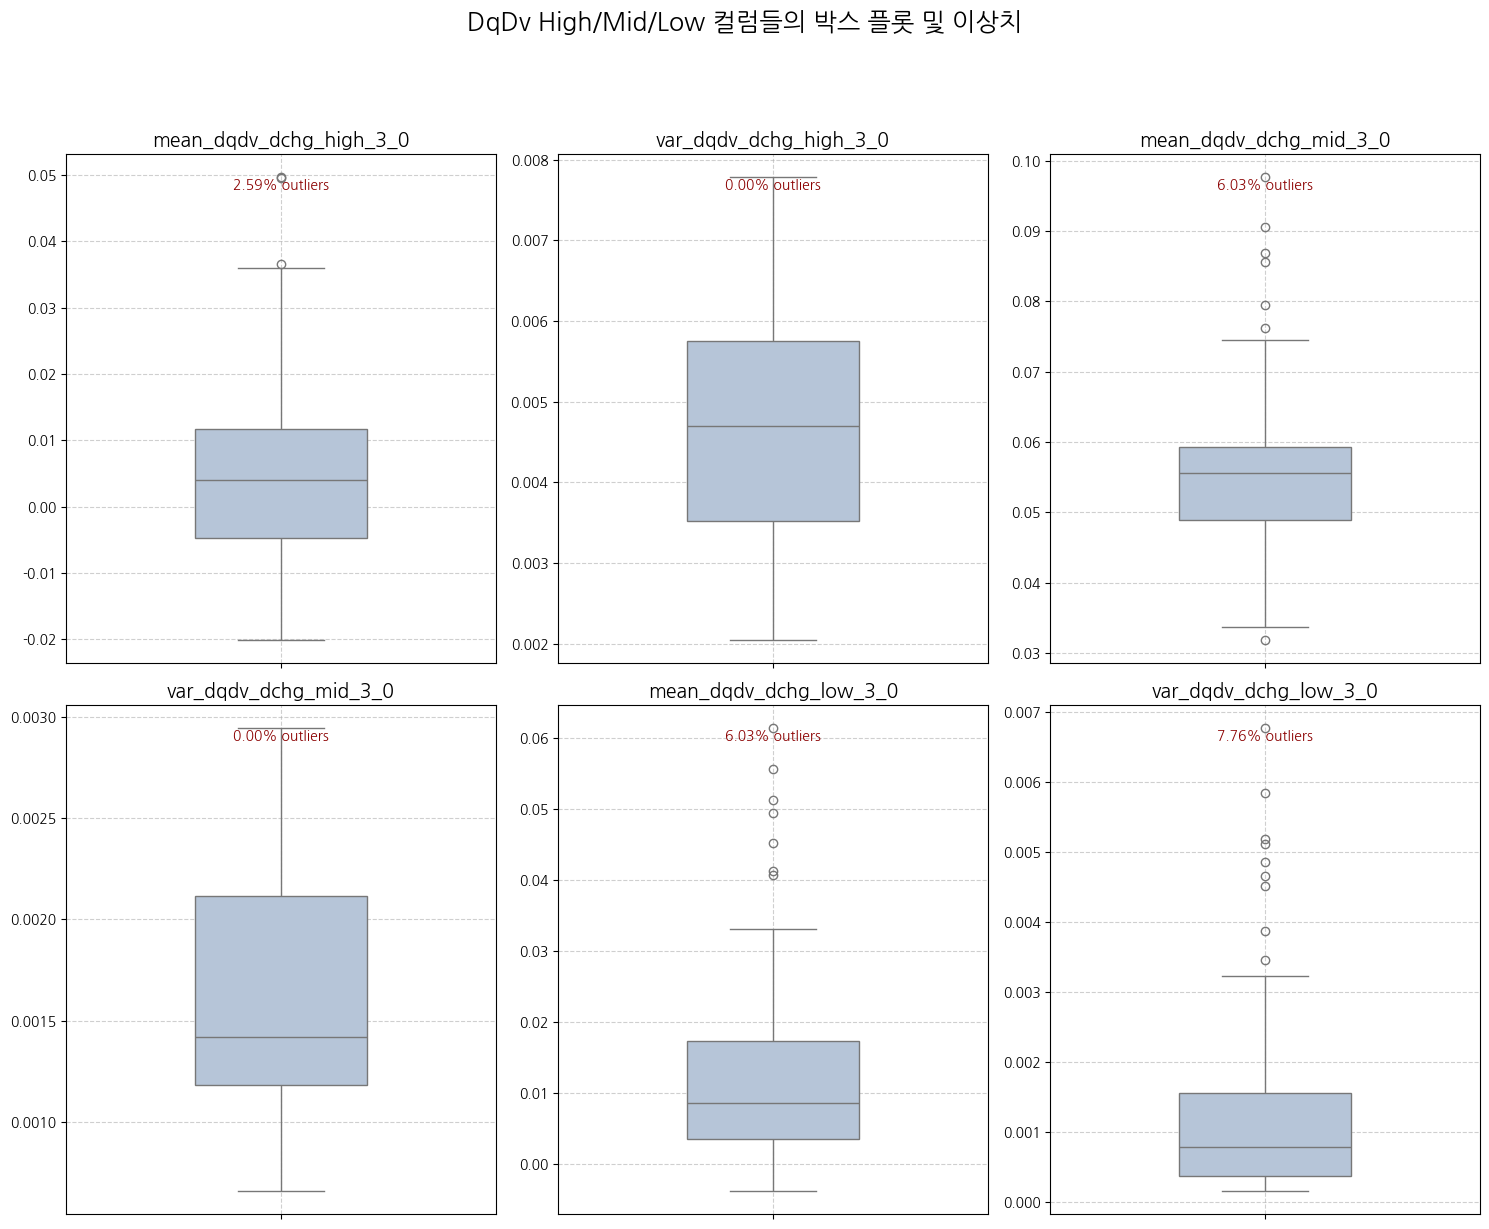

In [44]:
# --- 박스 플롯 그릴 컬럼 리스트 ---
cols_to_check_for_outliers = [
    'mean_dqdv_dchg_high_3_0', 'var_dqdv_dchg_high_3_0',
    'mean_dqdv_dchg_mid_3_0', 'var_dqdv_dchg_mid_3_0',
    'mean_dqdv_dchg_low_3_0', 'var_dqdv_dchg_low_3_0'
]

# --- 각 컬럼별 이상치 비율 계산 및 출력 ---
print("--- 요청된 DqDv High/Mid/Low 컬럼들의 이상치 비율 ---")
outlier_percentages = {}
for col in cols_to_check_for_outliers:
    if col in train_df.columns:
        percentage = calculate_outlier_percentage(train_df[col].dropna())
        outlier_percentages[col] = percentage
        print(f"'{col}': {percentage:.2f}%")
    else:
        print(f"⚠️ 경고: '{col}' 컬럼이 데이터프레임에 없습니다. (이름 확인 필요)")
        outlier_percentages[col] = np.nan # NaN으로 표시

# --- 박스 플롯 그리기 ---
# 서브플롯 개수 계산 (한 줄에 최대 3개 그래프)
n_cols_per_row = 3
n_rows = (len(cols_to_check_for_outliers) + n_cols_per_row - 1) // n_cols_per_row # 필요한 행 수 계산 (올림)

fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(n_cols_per_row * 5, n_rows * 6))
axes = axes.flatten() # 2D 배열을 1D로 평탄화하여 반복문에서 사용 용이하게 함

fig.suptitle('DqDv High/Mid/Low 컬럼들의 박스 플롯 및 이상치', fontsize=18, y=1.02) # 전체 제목

for i, col in enumerate(cols_to_check_for_outliers):
    if col in train_df.columns:
        sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightsteelblue', width=0.4)
        axes[i].set_title(col, fontsize=14)
        axes[i].set_ylabel('')
        axes[i].grid(True, linestyle='--', alpha=0.6)
        # 이상치 비율을 그래프 제목 아래에 표시
        if col in outlier_percentages and not np.isnan(outlier_percentages[col]):
            axes[i].text(0.5, 0.95, f'{outlier_percentages[col]:.2f}% outliers',
                         transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='darkred')
    else:
        axes[i].set_title(f"'{col}' 컬럼 없음", fontsize=14, color='red')
        axes[i].text(0.5, 0.5, "데이터에 컬럼이 없습니다.", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, color='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# 남는 서브플롯 공간은 숨기기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9) # 전체 제목이 잘리지 않도록 조정
plt.show()

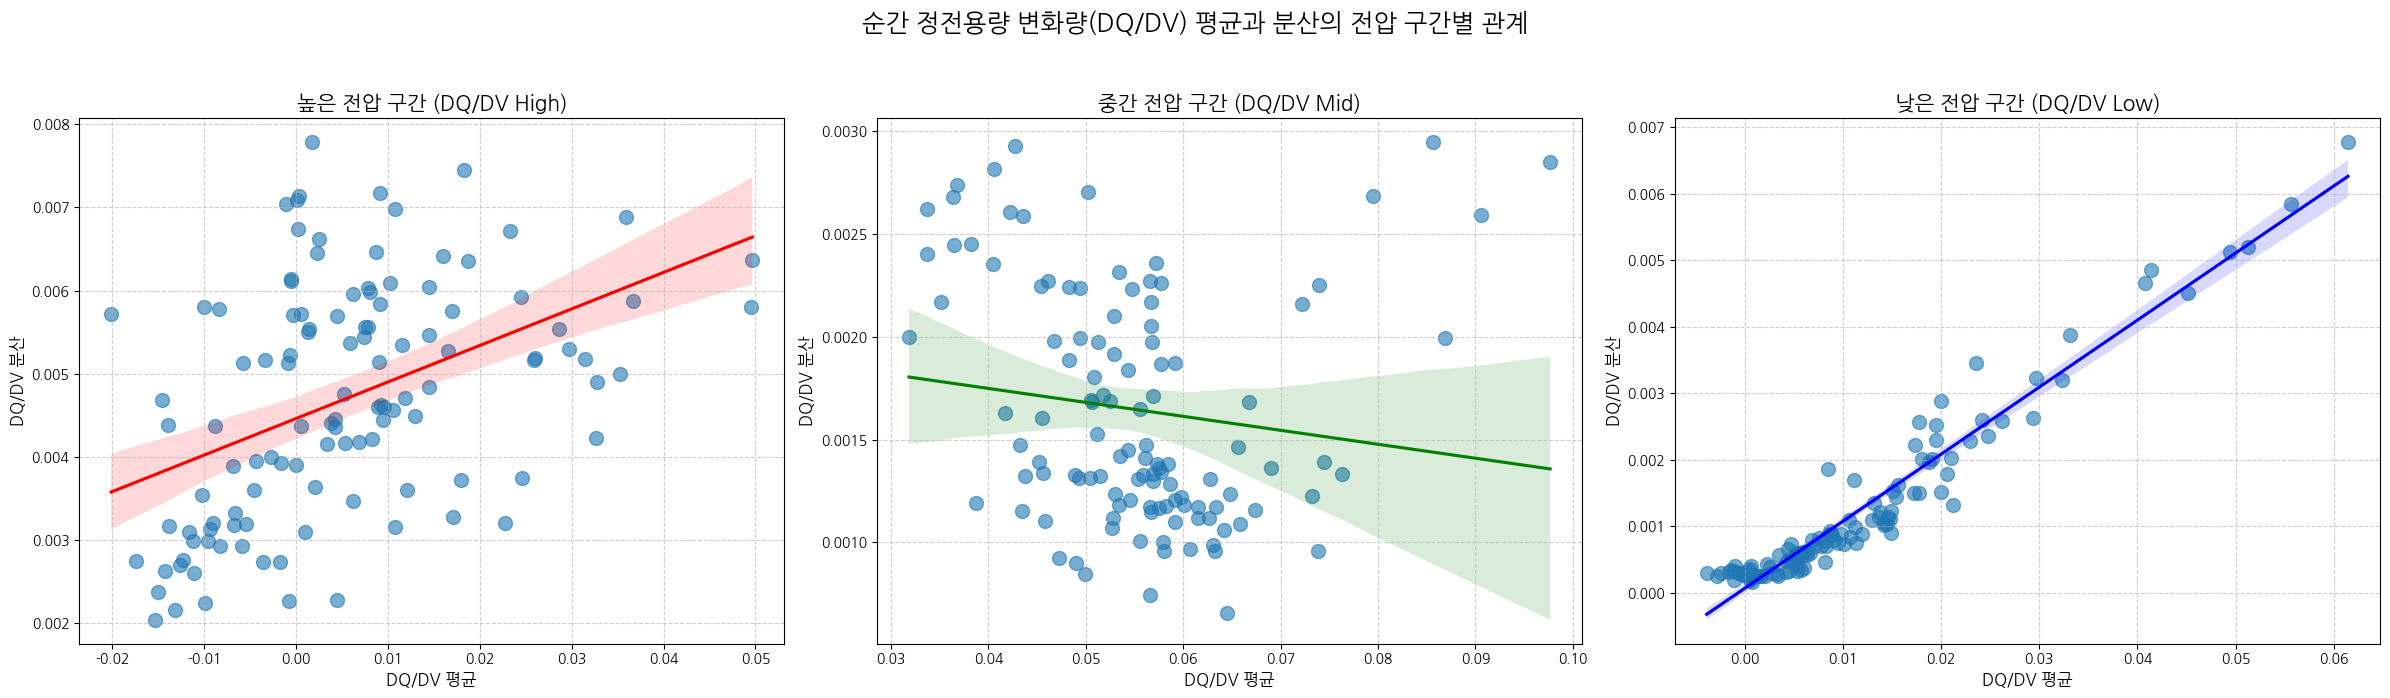

--- 높은 전압 구간 (DQ/DV High) 평균과 분산 간의 상관계수: 0.4438 ---
--- 중간 전압 구간 (DQ/DV Mid) 평균과 분산 간의 상관계수: -0.1378 ---
--- 낮은 전압 구간 (DQ/DV Low) 평균과 분산 간의 상관계수: 0.9685 ---


In [45]:
# --- 세 개의 서브플롯으로 산점도 그리기 ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) # 1행 3열의 서브플롯 생성

# 서브플롯 1: DQ/DV High
sns.regplot(x='mean_dqdv_dchg_high_3_0', y='var_dqdv_dchg_high_3_0',
            data=train_df.dropna(subset=['mean_dqdv_dchg_high_3_0', 'var_dqdv_dchg_high_3_0']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'red'},
            ax=axes[0])
axes[0].set_title('높은 전압 구간 (DQ/DV High)', fontsize=15)
axes[0].set_xlabel('DQ/DV 평균', fontsize=12)
axes[0].set_ylabel('DQ/DV 분산', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# 서브플롯 2: DQ/DV Mid
sns.regplot(x='mean_dqdv_dchg_mid_3_0', y='var_dqdv_dchg_mid_3_0',
            data=train_df.dropna(subset=['mean_dqdv_dchg_mid_3_0', 'var_dqdv_dchg_mid_3_0']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'green'},
            ax=axes[1])
axes[1].set_title('중간 전압 구간 (DQ/DV Mid)', fontsize=15)
axes[1].set_xlabel('DQ/DV 평균', fontsize=12)
axes[1].set_ylabel('DQ/DV 분산', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# 서브플롯 3: DQ/DV Low
sns.regplot(x='mean_dqdv_dchg_low_3_0', y='var_dqdv_dchg_low_3_0',
            data=train_df.dropna(subset=['mean_dqdv_dchg_low_3_0', 'var_dqdv_dchg_low_3_0']),
            scatter_kws={'alpha':0.6, 's':100},
            line_kws={'color':'blue'},
            ax=axes[2])
axes[2].set_title('낮은 전압 구간 (DQ/DV Low)', fontsize=15)
axes[2].set_xlabel('DQ/DV 평균', fontsize=12)
axes[2].set_ylabel('DQ/DV 분산', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('순간 정전용량 변화량(DQ/DV) 평균과 분산의 전압 구간별 관계', fontsize=18, y=1.02) # 전체 타이틀
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 그래프 간 간격 및 전체 타이틀 공간 조절
plt.show()

# --- 각 쌍의 상관계수 출력 ---
corr_high = train_df['mean_dqdv_dchg_high_3_0'].corr(train_df['var_dqdv_dchg_high_3_0'])
corr_mid = train_df['mean_dqdv_dchg_mid_3_0'].corr(train_df['var_dqdv_dchg_mid_3_0'])
corr_low = train_df['mean_dqdv_dchg_low_3_0'].corr(train_df['var_dqdv_dchg_low_3_0'])

print(f"--- 높은 전압 구간 (DQ/DV High) 평균과 분산 간의 상관계수: {corr_high:.4f} ---")
print(f"--- 중간 전압 구간 (DQ/DV Mid) 평균과 분산 간의 상관계수: {corr_mid:.4f} ---")
print(f"--- 낮은 전압 구간 (DQ/DV Low) 평균과 분산 간의 상관계수: {corr_low:.4f} ---")

1. 높은 전압 구간
- 배터리 충전이 완료되거나, 방전이 막 시작될 때의 특성
- 전극 물질의 구조적인 변화나 활성 물질의 반응이 비교적 선형적이고 예측가능하게 일어남

2. 낮은 전압 구간
- 배터리 방전이 거의 끝날 떄의 특성
- 특정 반응 메커니즘이 지배적임, 따라서 DQ/DV 곡선 형태가 일관된 패턴을 보임

3. 중간 전압 구간
- 가장 활발하게 에너지를 주고받는 주된 작동 범위
- 여러가지 복합적인 전기화학 반응이 일어남. 

각 팩터들이 강력하게 연결되어잇다.
해당 컬럼들이 Lifetime과 어떻게 강하게 연관되어잇는지 확인하는게 중요.
둘중 하나만으로도 충분히 타겟변수를 잘 설명한다면.  하나만 쓰는 것도 좋은 방법임

특성 공학 시도: 네가 생각한 "하나의 강력한 팩터"처럼, 의미 있는 비율이나 조합을 만들어보는 건 정말 해볼 만한 시도야!

PCA 고려: 만약 컬럼이 너무 많아지고 다중공선성 문제가 심각하다면, 최종적으로 PCA를 고려해볼 수 있어.

--- 각 컬럼과 Lifetime, capacity_fade_3_0 간의 선형 상관계수 ---

▶️ Lifetime과의 상관관계:
  'mean_dqdv_dchg_mid_3_0': -0.7439
  'mean_dqdv_dchg_high_3_0': -0.4929
  'var_dqdv_dchg_high_3_0': -0.4550
  'var_dqdv_dchg_low_3_0': -0.4355
  'mean_dqdv_dchg_low_3_0': -0.4007
  'var_dqdv_dchg_mid_3_0': 0.2856

▶️ capacity_fade_3_0과의 상관관계:
  'mean_dqdv_dchg_low_3_0': 0.9692
  'var_dqdv_dchg_low_3_0': 0.9384
  'mean_dqdv_dchg_high_3_0': 0.9113
  'mean_dqdv_dchg_mid_3_0': 0.8591
  'var_dqdv_dchg_high_3_0': 0.5478
  'var_dqdv_dchg_mid_3_0': -0.0750


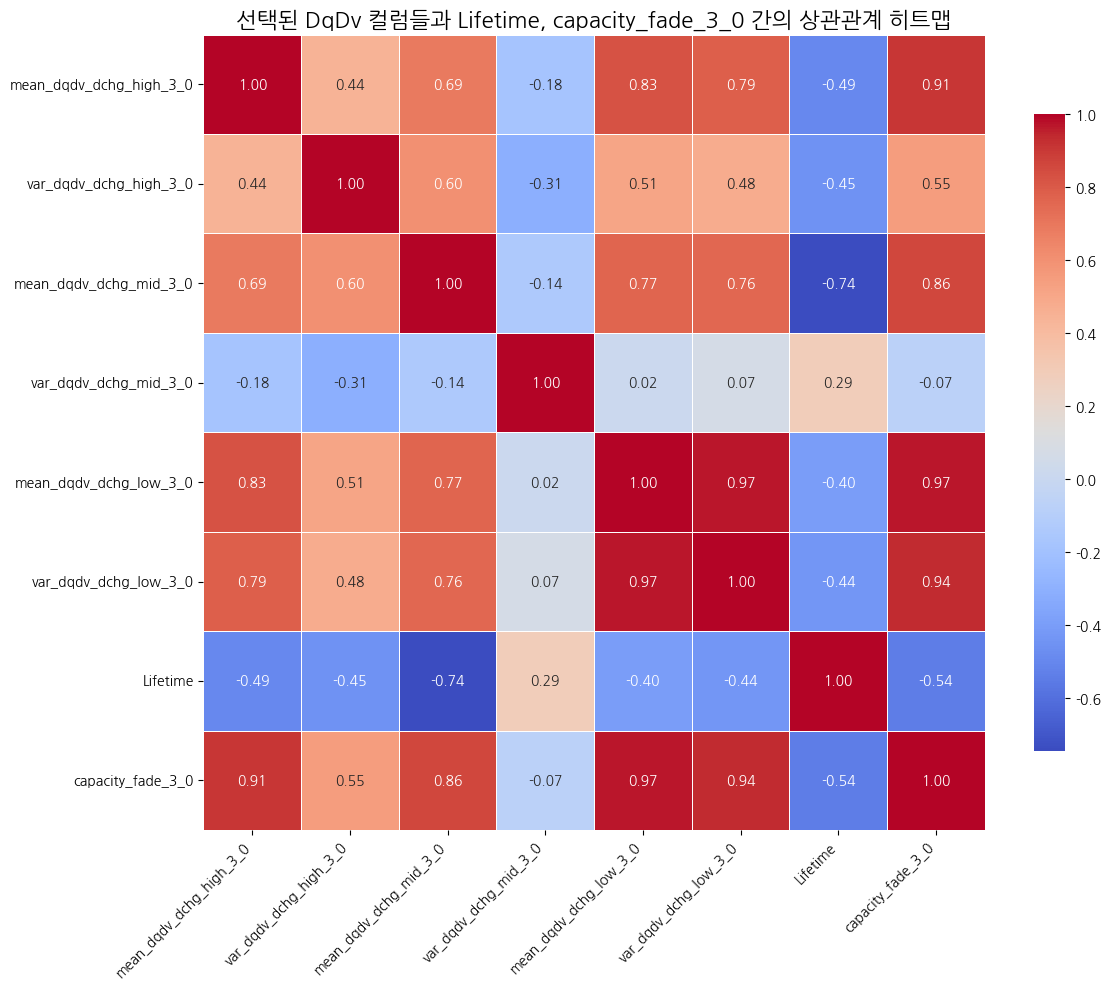

In [46]:
# 상관관계를 확인할 컬럼 리스트
target_cols = [
    'mean_dqdv_dchg_high_3_0', 'var_dqdv_dchg_high_3_0',
    'mean_dqdv_dchg_mid_3_0', 'var_dqdv_dchg_mid_3_0',
    'mean_dqdv_dchg_low_3_0', 'var_dqdv_dchg_low_3_0',
    'Lifetime',
    'capacity_fade_3_0'
]

# 실제로 데이터프레임에 존재하는 컬럼만 필터링
existing_cols = [col for col in target_cols if col in train_df.columns]

if len(existing_cols) < 2: # 최소 2개 이상의 컬럼이 있어야 상관계수 계산 가능
    print("⚠️ 경고: 분석할 수 있는 유효한 컬럼이 부족합니다. 데이터프레임에 필요한 컬럼이 있는지 확인해주세요.")
else:
    # 상관계수 계산
    correlation_matrix = train_df[existing_cols].corr()

    # Lifetime 및 capacity_fade_3_0과의 상관계수만 추출하여 출력
    print("--- 각 컬럼과 Lifetime, capacity_fade_3_0 간의 선형 상관계수 ---")
    
    # Lifetime과의 상관관계
    if 'Lifetime' in correlation_matrix.columns:
        print("\n▶️ Lifetime과의 상관관계:")
        # Lifetime 본인과 capacity_fade_3_0은 제외하고 출력
        lifetime_corrs = correlation_matrix['Lifetime'].drop(
            ['Lifetime'] + ([c for c in ['capacity_fade_3_0'] if c in correlation_matrix.columns])
        )
        if not lifetime_corrs.empty:
            sorted_lifetime_corrs = sorted(lifetime_corrs.items(), key=lambda item: abs(float(item[1])), reverse=True)
            for col, corr_val in sorted_lifetime_corrs:
                print(f"  '{col}': {corr_val:.4f}")
        else:
            print("  Lifetime과 상관관계를 볼 수 있는 다른 컬럼이 없습니다.")
    else:
        print("Lifetime 컬럼이 데이터프레임에 없습니다.")

    # capacity_fade_3_0과의 상관관계
    if 'capacity_fade_3_0' in correlation_matrix.columns:
        print("\n▶️ capacity_fade_3_0과의 상관관계:")
        # capacity_fade_3_0 본인과 Lifetime은 제외하고 출력
        capacity_fade_corrs = correlation_matrix['capacity_fade_3_0'].drop(
            ['capacity_fade_3_0'] + ([c for c in ['Lifetime'] if c in correlation_matrix.columns])
        )
        if not capacity_fade_corrs.empty:
            sorted_fade_corrs = sorted(capacity_fade_corrs.items(), key=lambda item: abs(float(item[1])), reverse=True)
            for col, corr_val in sorted_fade_corrs:
                print(f"  '{col}': {corr_val:.4f}")
        else:
            print("  capacity_fade_3_0과 상관관계를 볼 수 있는 다른 컬럼이 없습니다.")
    else:
        print("capacity_fade_3_0 컬럼이 데이터프레임에 없습니다.")
    

    # 히트맵 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('선택된 DqDv 컬럼들과 Lifetime, capacity_fade_3_0 간의 상관관계 히트맵', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


'skew_deltaQ',
    'min_deltaQ',
    'var_deltaQ',
    'kurt_deltaQ

--- 요청된 deltaQ 관련 컬럼들의 이상치 비율 ---
'skew_deltaQ': 0.00%
'min_deltaQ': 6.03%
'var_deltaQ': 8.62%
'kurt_deltaQ': 0.00%


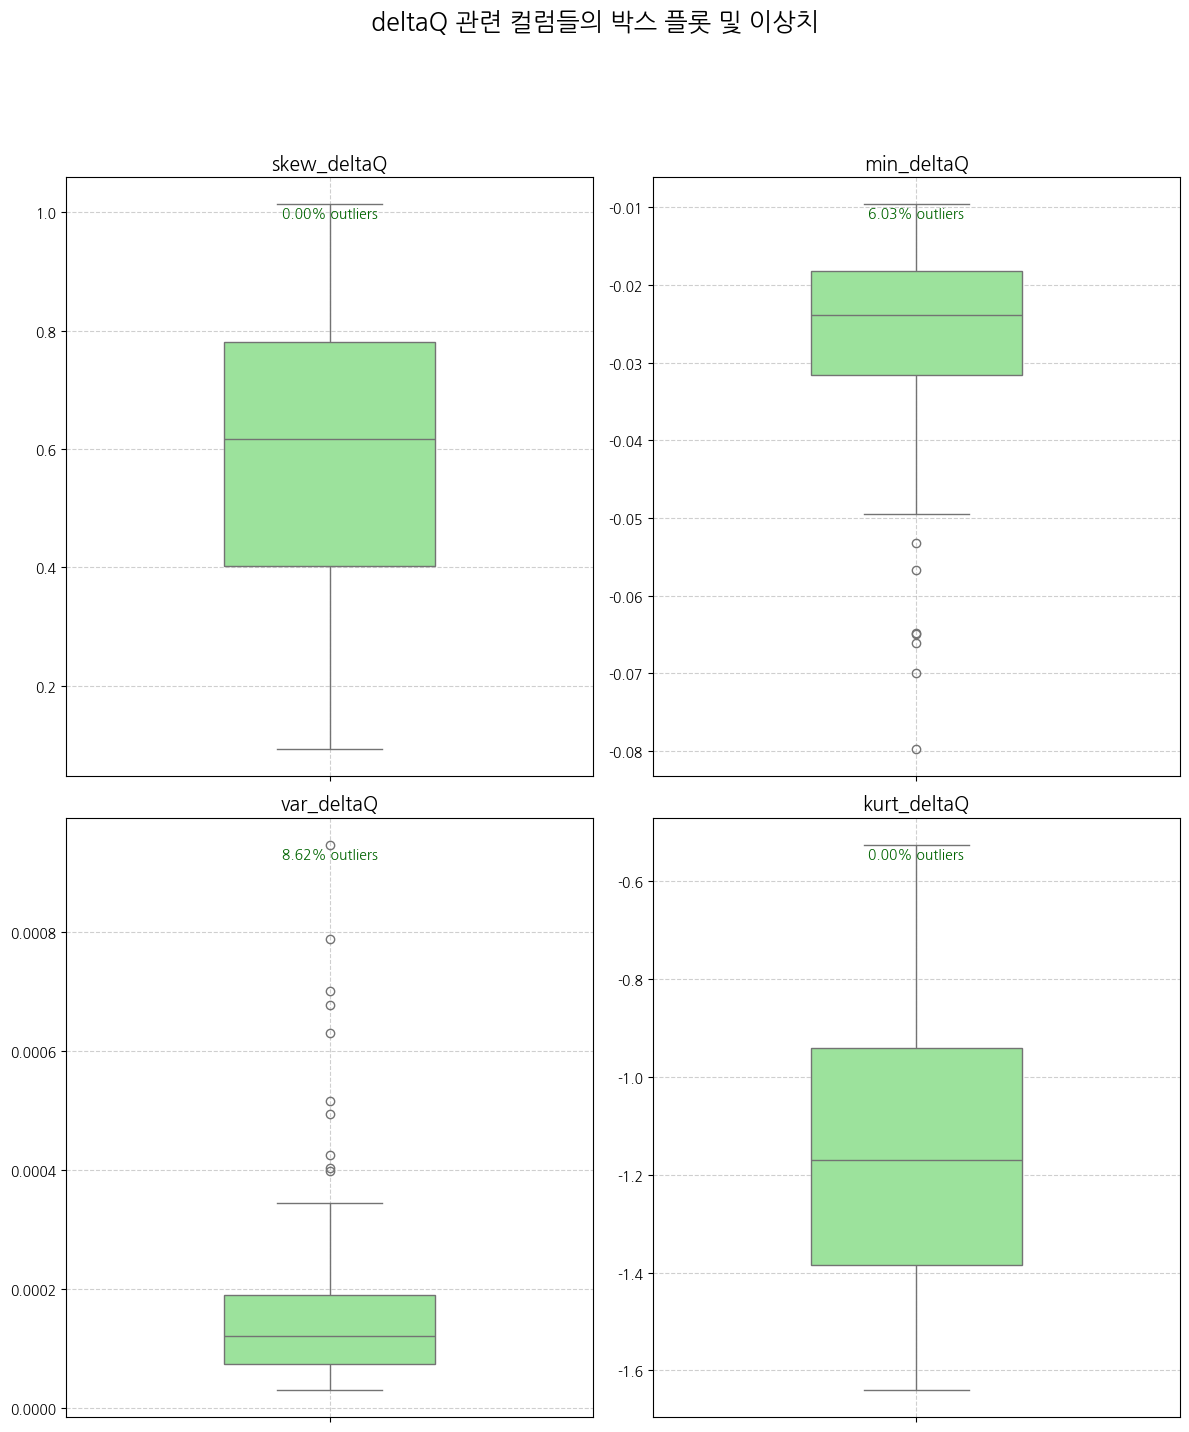

In [47]:
# --- 박스 플롯 그릴 컬럼 리스트 ---
cols_to_check_for_outliers = [
    'skew_deltaQ',
    'min_deltaQ',
    'var_deltaQ',
    'kurt_deltaQ'
]

# --- 각 컬럼별 이상치 비율 계산 및 출력 ---
print("--- 요청된 deltaQ 관련 컬럼들의 이상치 비율 ---")
outlier_percentages = {}
for col in cols_to_check_for_outliers:
    if col in train_df.columns:
        percentage = calculate_outlier_percentage(train_df[col].dropna())
        outlier_percentages[col] = percentage
        print(f"'{col}': {percentage:.2f}%")
    else:
        print(f"⚠️ 경고: '{col}' 컬럼이 데이터프레임에 없습니다. (이름 확인 필요)")
        outlier_percentages[col] = np.nan # NaN으로 표시

# --- 박스 플롯 그리기 ---
# 서브플롯 개수 계산 (한 줄에 최대 2개 그래프)
n_cols_per_row = 2
n_rows = (len(cols_to_check_for_outliers) + n_cols_per_row - 1) // n_cols_per_row # 필요한 행 수 계산 (올림)

fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(n_cols_per_row * 6, n_rows * 7))
axes = axes.flatten() # 2D 배열을 1D로 평탄화하여 반복문에서 사용 용이하게 함

fig.suptitle('deltaQ 관련 컬럼들의 박스 플롯 및 이상치', fontsize=18, y=1.02) # 전체 제목

for i, col in enumerate(cols_to_check_for_outliers):
    if col in train_df.columns:
        sns.boxplot(y=train_df[col].dropna(), ax=axes[i], color='lightgreen', width=0.4)
        axes[i].set_title(col, fontsize=14)
        axes[i].set_ylabel('')
        axes[i].grid(True, linestyle='--', alpha=0.6)
        # 이상치 비율을 그래프 제목 아래에 표시
        if col in outlier_percentages and not np.isnan(outlier_percentages[col]):
            axes[i].text(0.5, 0.95, f'{outlier_percentages[col]:.2f}% outliers',
                         transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='darkgreen')
    else:
        axes[i].set_title(f"'{col}' 컬럼 없음", fontsize=14, color='red')
        axes[i].text(0.5, 0.5, "데이터에 컬럼이 없습니다.", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, color='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# 남는 서브플롯 공간은 숨기기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9) # 전체 제목이 잘리지 않도록 조정
plt.show()

--- deltaQ 관련 컬럼들 간의 선형 상관계수 ---
  'skew_deltaQ' vs 'min_deltaQ': 0.8619
  'skew_deltaQ' vs 'var_deltaQ': -0.7852
  'skew_deltaQ' vs 'kurt_deltaQ': 0.9759
  'min_deltaQ' vs 'var_deltaQ': -0.9725
  'min_deltaQ' vs 'kurt_deltaQ': 0.8362
  'var_deltaQ' vs 'kurt_deltaQ': -0.7322


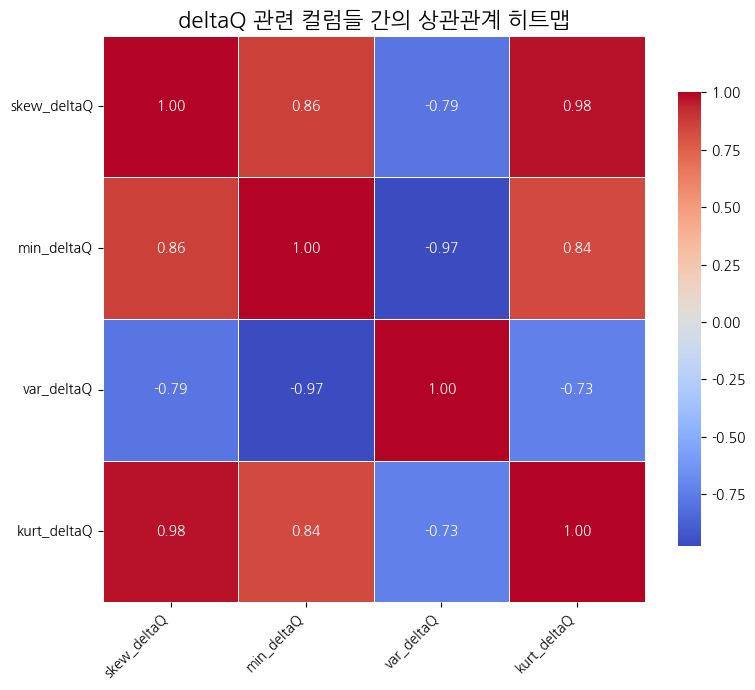

In [48]:
# 상관관계를 확인할 컬럼 리스트
target_cols = [
    'skew_deltaQ',
    'min_deltaQ',
    'var_deltaQ',
    'kurt_deltaQ'
]

# 실제로 데이터프레임에 존재하는 컬럼만 필터링
existing_cols = [col for col in target_cols if col in train_df.columns]

if len(existing_cols) < 2: # 최소 2개 이상의 컬럼이 있어야 상관계수 계산 가능
    print("⚠️ 경고: 분석할 수 있는 유효한 컬럼이 부족합니다. 데이터프레임에 필요한 컬럼이 있는지 확인해주세요.")
else:
    # 상관계수 계산
    correlation_matrix = train_df[existing_cols].corr()

    # 각 컬럼 쌍 간의 상관계수 출력
    print("--- deltaQ 관련 컬럼들 간의 선형 상관계수 ---")
    for i in range(len(existing_cols)):
        for j in range(i + 1, len(existing_cols)):
            col1 = existing_cols[i]
            col2 = existing_cols[j]
            corr_val = correlation_matrix.loc[col1, col2]
            print(f"  '{col1}' vs '{col2}': {corr_val:.4f}")

    # 히트맵 시각화
    plt.figure(figsize=(8, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('deltaQ 관련 컬럼들 간의 상관관계 히트맵', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


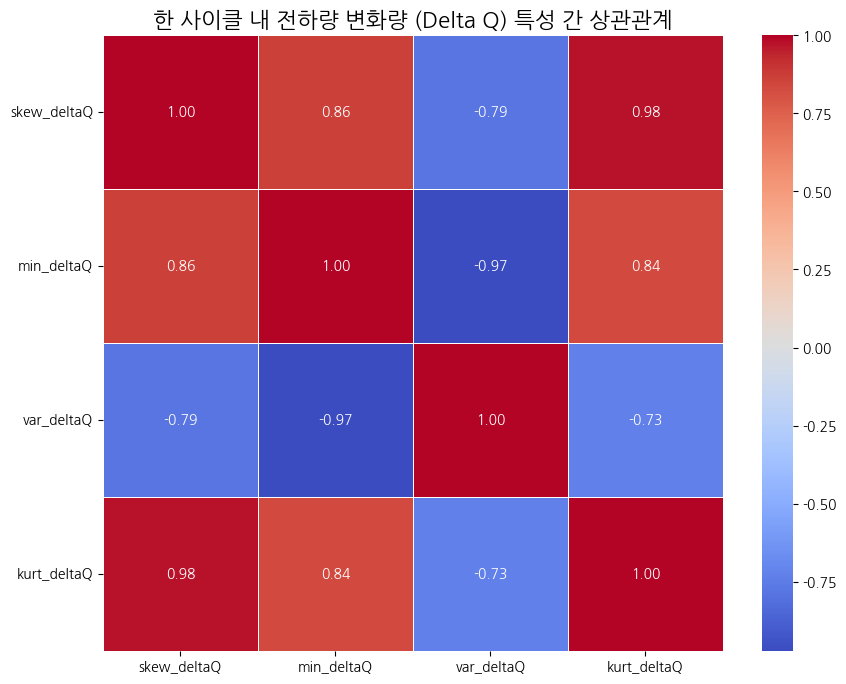


--- 각 특성 간의 상관계수 (매트릭스) ---
             skew_deltaQ  min_deltaQ  var_deltaQ  kurt_deltaQ
skew_deltaQ       1.0000      0.8619     -0.7852       0.9759
min_deltaQ        0.8619      1.0000     -0.9725       0.8362
var_deltaQ       -0.7852     -0.9725      1.0000      -0.7322
kurt_deltaQ       0.9759      0.8362     -0.7322       1.0000


In [49]:
# --- 상관관계 계산을 위한 컬럼 리스트 ---
deltaQ_features = [
    'skew_deltaQ',
    'min_deltaQ',
    'var_deltaQ',
    'kurt_deltaQ'
]

# 해당 컬럼들만 선택하여 상관관계 매트릭스 계산
correlation_matrix = train_df[deltaQ_features].corr()

# --- 히트맵으로 시각화 ---
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,      # 각 셀에 상관계수 값 표시
            cmap='coolwarm', # 색상 팔레트 설정 (음수-양수 구분)
            fmt=".2f",       # 소수점 둘째 자리까지 표시
            linewidths=.5)   # 셀 간 구분선 두께

plt.title('한 사이클 내 전하량 변화량 (Delta Q) 특성 간 상관관계', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0) # y축 레이블 회전 방지
plt.show()

print("\n--- 각 특성 간의 상관계수 (매트릭스) ---")
print(correlation_matrix.to_string(float_format="%.4f"))

In [ ]:
전체적인 데이터의 패턴을 확인 후 모델을 결정한다.  
1) 이상치가 존재
2) 비선형 관계 많음
3) 다중공선성 존재
4) 데이터 크기가 작음 

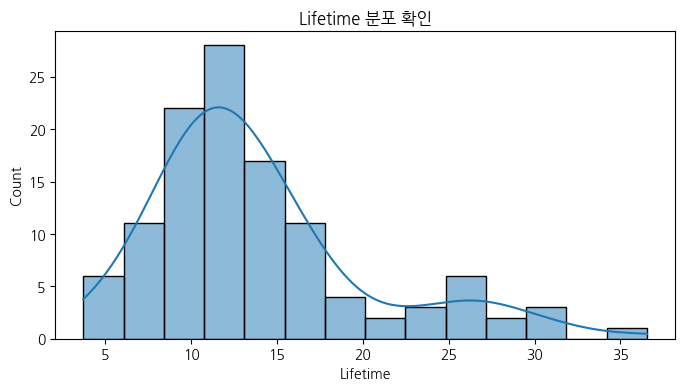

In [73]:
plt.figure(figsize=(8, 4))
sns.histplot(train_df['Lifetime'], kde=True)
plt.title('Lifetime 분포 확인')
plt.show()


# ------------------------------------------------------------
불러온 평가용 데이터의 일부를 확인해봅시다.

In [64]:
print("Train Data 크기 :", train_df.shape)
print("Test Data 크기 :", test_x.shape)

Train Data 크기 : (116, 39)
Test Data 크기 : (109, 34)


## 데이터 전처리

1. 결측치가 있는지 확인합니다.

In [65]:
na_columns_train = train_x.columns[train_x.isna().any()]
na_columns_test = test_x.columns[test_x.isna().any()]
na_columns = set(na_columns_train) | set(na_columns_test)
na_columns

set()

2. 데이터를 정규화 합니다.

In [66]:
# 데이터 정규화

scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [67]:
print("Train Data 크기 :", train_x.shape)
print("Test Data 크기 :", test_x.shape)

Train Data 크기 : (116, 34)
Test Data 크기 : (109, 34)


## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 서포트 벡터 머신 기반 회귀 예측 모델 (SVR) 을 사용합니다.

In [68]:
model = SVR()
model.fit(train_x, train_y)

SVR()

학습 데이터에 대한 성능을 확인합니다.

In [69]:
pred_train = model.predict(train_x)
print("MAPE Score for Train: ", mean_absolute_percentage_error(train_y, pred_train))

MAPE Score for Train:  0.3372056399070536


## 모델 평가 및 결과 저장

회귀 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **MAPE Score** 지표를 활용하여 순위를 결정할 것입니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에 나와 있는 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

In [70]:
# 제출 템플릿을 불러옵니다.
submission = pd.read_csv("submission.csv", index_col=0)

# 테스트 데이터에 대한 예측 결과를 저장합니다.
# Note. 예시 코드에서는 index(Cell_ID)의 순서를 수정하지 않아서 예측 결과를 바로 템플릿에 할당했지만, 
# 만약 학습 과정에서 index를 수정하셨다면, sort_index() 등으로 index를 맞추는 것을 권장 드립니다.
submission["Lifetime"] = model.predict(test_x)
submission.to_csv("submission.csv")

### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [71]:
submission = pd.read_csv("submission.csv", index_col=0)
submission

Lifetime
Cell_ID           
1065Q    12.569012
1088R    12.226048
1235T    12.132744
1479K    12.487233
1552R    12.042100
...            ...
9242Y    12.083966
9601Y    12.603540
9726A    12.472272
9856I    12.162875
9921R    12.313520

[109 rows x 1 columns]

### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일